# Sunrise Demo

## Setup

In [1]:
from __future__ import annotations
# %pip install --quiet --upgrade pip
# %pip install --upgrade --force-reinstall git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
# try:
#     __import__('importlib').reload(__import__('sys').modules['mediocreatbest'])
# except KeyError:
#     print(f'Module "mediocreatbest" not in sys.modules?')
from mediocreatbest import auto, run
auto.register('mediocreatbest', 'git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git')

In [2]:
def __numpy_string_function(arr):
    name = arr.__class__.__name__
    if arr.size < 1024:
        values = auto.numpy.array_repr(auto.numpy.ravel(arr))
    else:
        values = '...'
        
    shape = auto.numpy.shape(arr)
    dtype = arr.dtype
    return f'{name}({values}, {shape=!r}, {dtype=!r})'
auto.numpy.set_string_function(__numpy_string_function, repr=False)
auto.numpy.set_string_function(__numpy_string_function, repr=True)

auto.np.set_printoptions(
    threshold=4,
    edgeitems=0,
)

## Domain Modeling

### Typing

In [3]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

### Location (lat, lng, alt) to spatial (x, y, z)

In [4]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    math=auto.math,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = math.radians(lat)
    theta: Radian = math.radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = math.cos(phi) * math.cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = math.cos(phi) * math.sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = math.sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

### Tile (zoom, x, y) to location (lat, lng)

In [5]:
@auto.mediocreatbest.doctest
def convert_tile_coordinates_to_latlng(
    *,
    z: int,
    x: int,
    y: int,
    math=auto.numpy,
    return_google_maps_url: bool=False,
) -> Tuple[Degree, Degree]:
    r"""

    >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'

    """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    #> n = 2 ^ zoom
    n = 2 ** z
    
    #> lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0
    
    #> lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = math.arctan(math.sinh(math.pi * (1.0 - 2.0 * y / n)))
    
    #> lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

### Dataclasses

In [6]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.x,
            y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: Degree
    lng: Degree
    alt: Optional[Meter] = auto.dataclasses.field(default=None)

@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: Kilometer
    y: Kilometer
    z: Kilometer

In [7]:
# @dispatch
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Tixel:
    y: int
    x: int
        
    z: ClassVar[int] = 23
        
    @property
    def location(self) -> Location:
        """Center lat/lng of current tixel"""
        lat, lng = tile_coordinates_to_latlng(
            z=1+self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

# @Tixel.register
# def __tixel_from_coord(coord: Coord, /, *, res: int):
#     dz = int(auto.math.log2(Tixel.z - coord.z))
    
    

### URL

In [8]:
@auto.dataclasses.dataclass
class TileURL:
    scheme: str
    netloc: str
    prefix: str
    z: int
    x: int
    y: int
    suffix: str
    query: Dict[str, str]
    fragment: str

    @classmethod
    @auto.mediocreatbest.doctest
    def decode(cls, url: str) -> Self:
        r"""
        
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov',
         'prefix': ['', 'styles', 'v1', 'atlas-user', 'ck58pyquo009v01p99xebegr9', 'tiles', '256'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '@2x',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov:443',
         'prefix': ['', 'v4', 'atlas-user.0000214_pink'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '.png',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        
        """
        
        scheme, netloc, path, query, fragment = auto.urllib.parse.urlsplit(
            url,
        )
        path = path.split('/')
        *prefix, z, x, suffix = path
        assert (match := auto.re.match(r'^(\d+)(.*)$', suffix)) is not None, \
            f'{suffix = !r}'
        y, suffix = match.groups()
            
        
        z, x, y = map(int, (z, x, y))
        query = auto.urllib.parse.parse_qsl(
            query,
        )

        return cls(
            scheme=scheme,
            netloc=netloc,
            prefix=prefix,
            z=z,
            x=x,
            y=y,
            suffix=suffix,
            query=query,
            fragment=fragment,
        )

    def encode(self) -> str:
        query = auto.urllib.parse.urlencode(
            self.query,
            doseq=True,
        )
        
        z, x, y = map(str, (self.z, self.x, self.y))

        path = '/'.join([
            *self.prefix,
            z,
            x,
            y + self.suffix,
        ])

        return auto.urllib.parse.urlunsplit((
            self.scheme,
            self.netloc,
            path,
            query,
            self.fragment,
        ))
    

## HTTP Request Caching

In [9]:
@run(cond='cache' not in auto.mediocreatbest.g)
def cache():
    return {}

@run
def cache(cache, /):
    def load() -> Dict:
        ret = {}
        try:
            with open(path, 'rb') as f:
                ret = auto.pickle.load(f)
                print(f'Read {f.tell():,d} bytes from {path}')
        except Exception as e:
            print('load failed:')
            auto.traceback.print_exception(e)
        
        return ret
    
    def merge(mutable: Dict, constant: Dict):
        try:
            for k, v in constant.items():
                if k in mutable:
                    continue

                mutable[k] = v
        except Exception as e:
            print('merge failed:')
            auto.traceback.print_exception(e)
    
    def dump(d: Dict):
        try:
            with open(path, 'wb') as f:
                auto.pickle.dump(d, f)

                print(f'Wrote {f.tell():,d} bytes to {path}')
        except Exception as e:
            print('dump failed:')
            auto.traceback.print_exception(e)
        
    path = auto.pathlib.Path.cwd() / 'tmp' / 'Sunrise Demo Cache.pickle'
    
    if path.exists():
        merge(cache, load())
    
    dump(cache)
    
    return cache

Read 29,750,594 bytes from /home/thobson2/src/Sunrise-Demo/tmp/Sunrise Demo Cache.pickle
Wrote 29,750,594 bytes to /home/thobson2/src/Sunrise-Demo/tmp/Sunrise Demo Cache.pickle


In [10]:
@run
def fetch(cache, /):
    def fetch(url: str, *, tqdm=None) -> bytes:
        key = url
        if key not in cache:
            if tqdm is not None:
                tqdm.set_description(f'Cache Miss: {url}')

            with auto.requests.get(url) as r:
                r.raise_for_status()
                cache[key] = r.content
            
            auto.time.sleep(1)
        
        else:
            if tqdm is not None:
                tqdm.set_description('Cache Hit: {url}')
        
        return cache[key]

    return fetch

## Observations

In [11]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Observation:
    common_name: str
    irma_id: str
    latin_name_ref: str
    latin_name: str

@run
def observations(fetch, /):
    observations = []
    for observation in (
        Observation(**kwargs)
        for kwargs in (
            auto.json.loads(fetch('https://species.atlasofthesmokies.org/atbirecords/lexical_index.json'))
        )['items']
    ):
        observations.append(observation)
    
    return observations

In [12]:
@run(after=print)
def observation(observations, /):
    for observation in observations:
        if observation.common_name not in [
            'Alternate-Leaf Dogwood',
#             'A Spiny Crawler Mayfly',
#             'Acadian Flycatcher',
#             'Agreeable Tiger Moth',
        ]:
            continue
        
        return observation

Observation(common_name='Alternate-Leaf Dogwood', irma_id='0010099', latin_name_ref='Cornus alternifolia', latin_name='Cornus_alternifolia')


In [13]:
@run(scope='observation')
def db(observation, /):
    @auto.mediocreatbest.contextgenerator(call=lambda generator: lambda sql, /, **parameters: generator.send((sql, parameters)))
    def db(observation: Observation=observation, /):
        root = auto.pathlib.Path('/mnt/seenas2/data/johns_nps_run/maxent/mbtiles/out')
        path = root / f'atlas-user.{observation.irma_id}_pink.mbtiles'
        
        with auto.sqlite3.connect(path) as db:
            db.row_factory = auto.sqlite3.Row
            
            cursor = None
            while True:
                sql, parameters = yield cursor
                cursor = db.execute(sql, parameters)
    
    return db

@run(scope='observation', after=print)
def z():
    z = 15
    return z

@auto.dataclasses.dataclass(eq=True, frozen=True)
class ObservationTile:
    coord: Coord
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='observation', after=lambda tiles: print(f'{len(tiles)=!r}'))
def tiles(db, z, /):
    with db() as db:
        tiles = []
        for tile in db(r'''
            SELECT
                tile_row AS y_tms,
                tile_column AS x,
                zoom_level AS z,
                tile_data AS image
            FROM tiles
            WHERE zoom_level = :z
        ''', z=z):
            tiles.append(ObservationTile(
                coord=Coord(
                    z=tile['z'],
                    y=2 ** tile['z'] - 1 - tile['y_tms'],
                    x=tile['x'],
                ),
                image=tile['image'],
            ))
    
    return tiles

@run(scope='observation', after=print)
def xs(tiles, /):
    return sorted(set(tile.coord.x for tile in tiles))

@run(scope='observation', after=print)
def ys(tiles, /):
    return sorted(set(tile.coord.y for tile in tiles))


15
len(tiles)=2214
[8738, 8739, 8740, 8741, 8742, 8743, 8744, 8745, 8746, 8747, 8748, 8749, 8750, 8751, 8752, 8753, 8754, 8755, 8756, 8757, 8758, 8759, 8760, 8761, 8762, 8763, 8764, 8765, 8766, 8767, 8768, 8769, 8770, 8771, 8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8792, 8793, 8794, 8795, 8796, 8797, 8798, 8799, 8800, 8801, 8802, 8803, 8804, 8805, 8806, 8807, 8808, 8809, 8810, 8811, 8812, 8813, 8814, 8815, 8816, 8817, 8818, 8819, 8820, 8821, 8822, 8823, 8824, 8825]
[12890, 12891, 12892, 12893, 12894, 12895, 12896, 12897, 12898, 12899, 12900, 12901, 12902, 12903, 12904, 12905, 12906, 12907, 12908, 12909, 12910, 12911, 12912, 12913, 12914, 12915, 12916, 12917, 12918, 12919, 12920, 12921, 12922, 12923, 12924, 12925, 12926, 12927, 12928, 12929, 12930, 12931]


In [14]:
def __stitch_tiles(tiles, /, size: int=128):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = size
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        with auto.io.BytesIO(tile.image) as f:
            try:
                image = Image.open(f)
            except auto.PIL.UnidentifiedImageError:
                continue

            image.thumbnail((sz, sz))

        composite.paste(image, (xi*sz, yi*sz))
    
    return composite

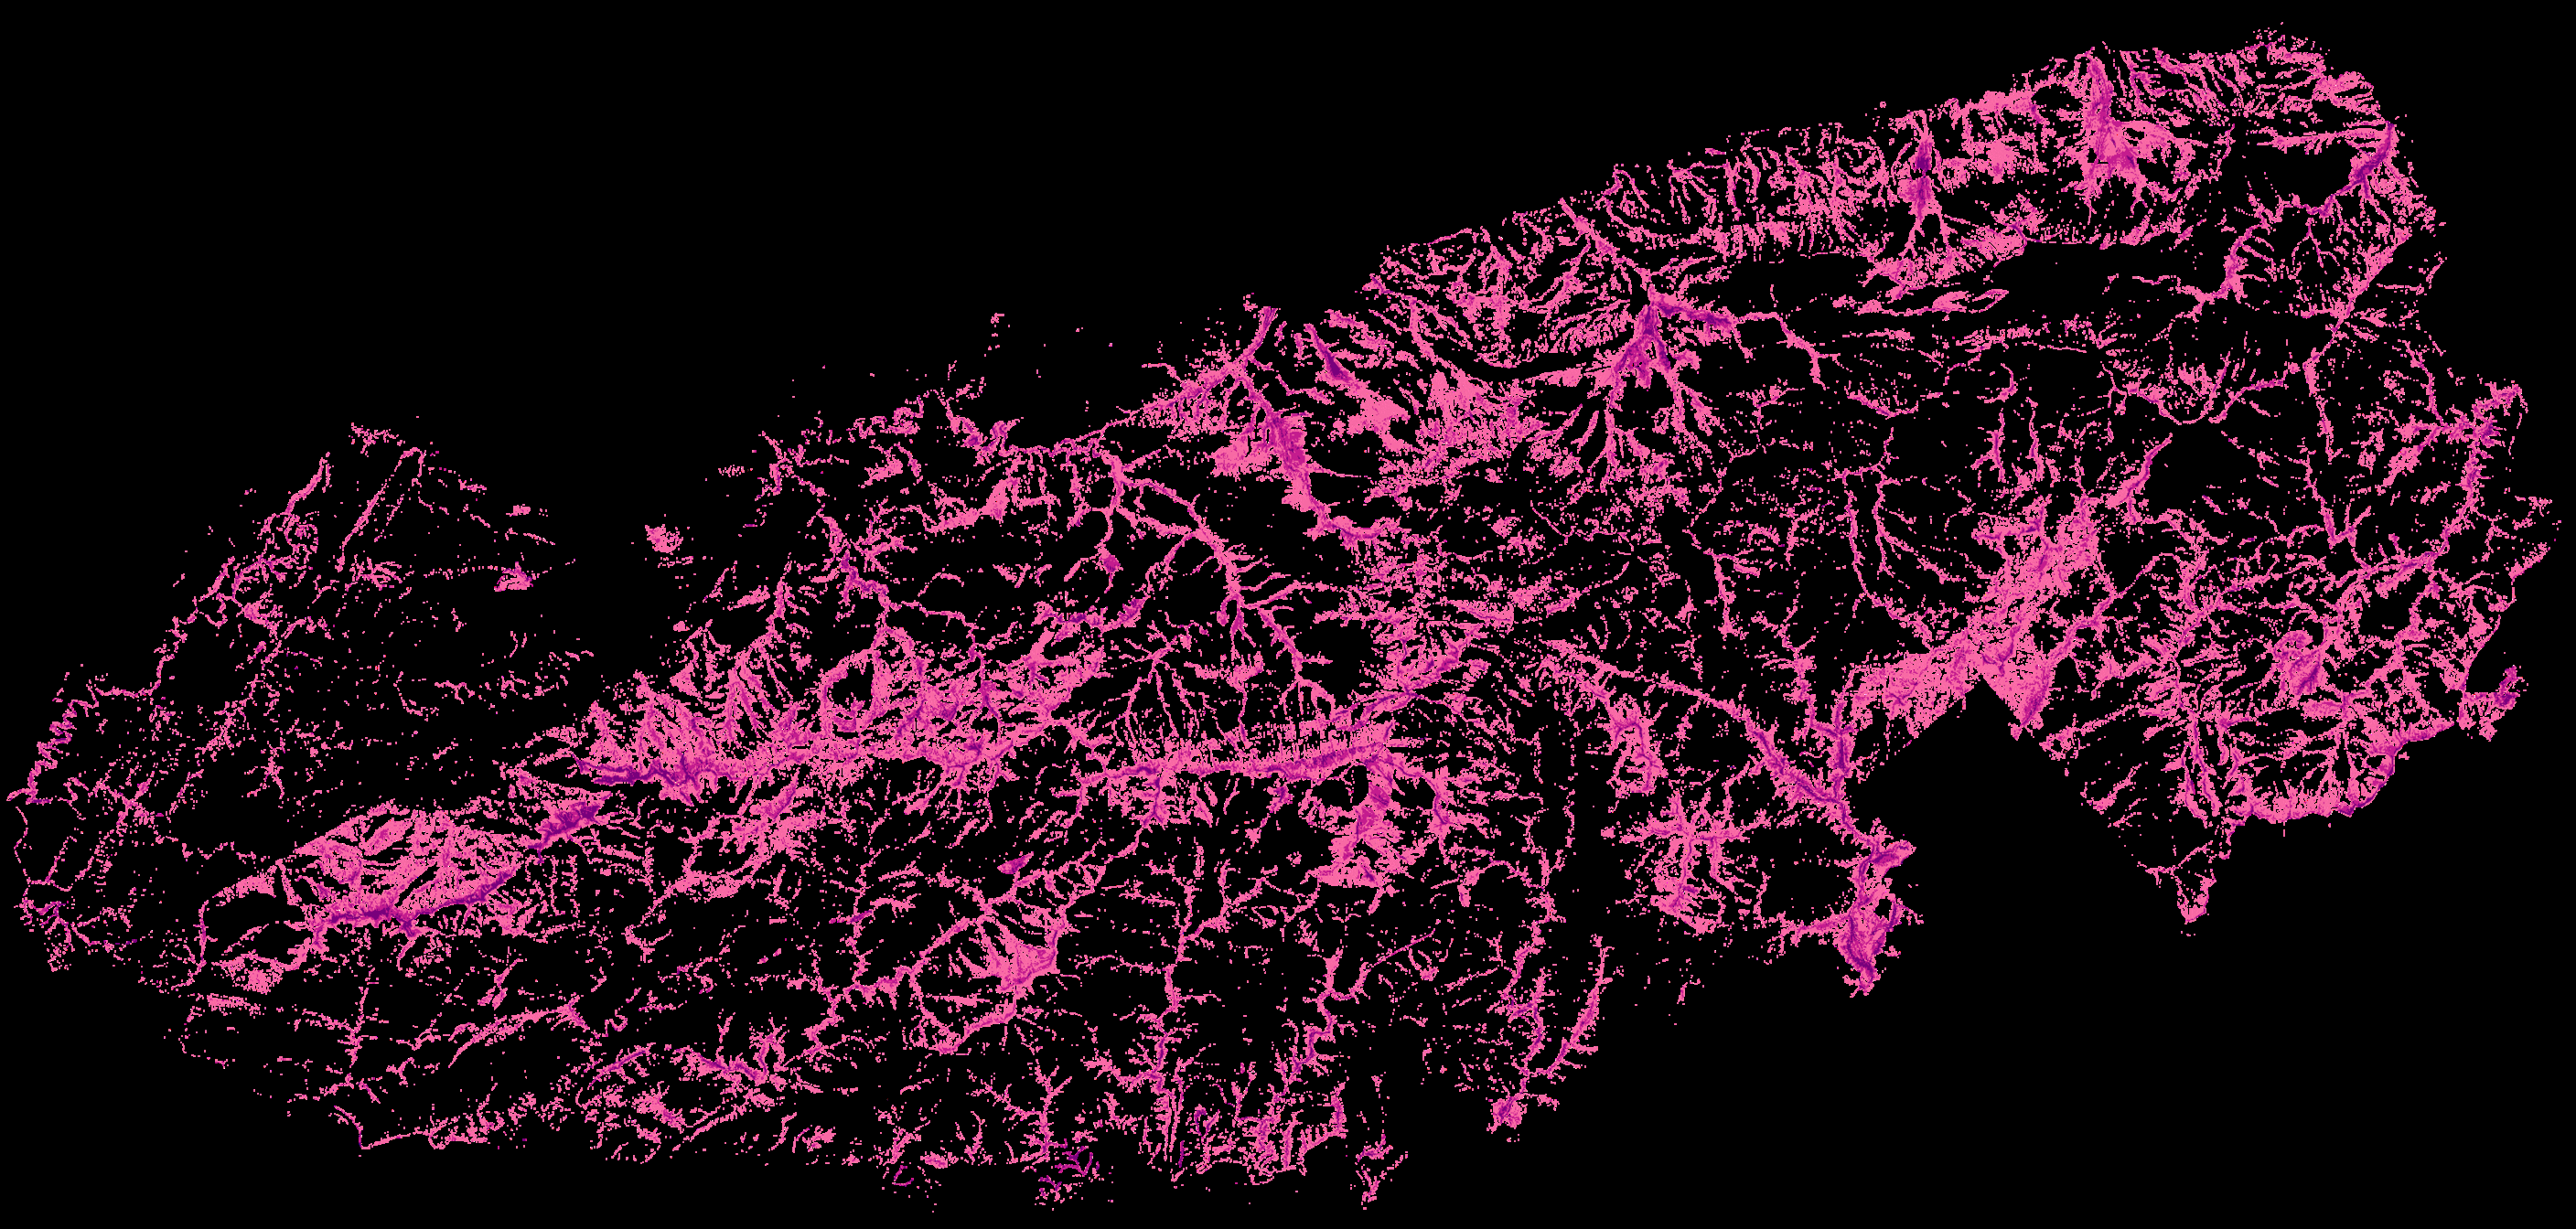

In [15]:
__stitch_tiles(auto.mediocreatbest.g['observation__tiles'], size=32)

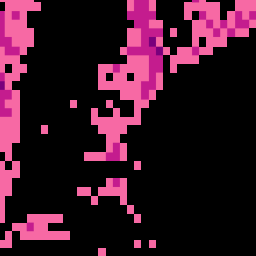

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 3696/3696 [00:31<00:00, 116.00it/s]


In [16]:
@run(scope='observation')
def interpolator(tiles, z, xs, ys, /):
    res = 256
    
    # Thanks https://species.atlasofthesmokies.org/style.css
    pinks = auto.numpy.array([
        # Black, obviously.
        # Represents 0-25%
        [0, 0, 0],

        #> #legend-pink-50 { background-color: #f069a3; }
        # Represents 25-50%
        [247, 105, 164],

        #> #legend-pink-75 { background-color: #c31d8e; }
        # Represents 50-75%
        [196, 28, 142],

        #> #legend-pink-100 { background-color: #752879; }
        # Represents 75-100%
        [121, 0, 124],
    ], dtype=auto.numpy.uint8)
    
    @auto.mediocreatbest.coroutine
    def display():
        handle = auto.IPython.display.display(None, display_id=True)
        
        while True:
            obj = yield
            handle.update(obj)
        
    @auto.mediocreatbest.coroutine  # (call=lambda gen: lambda *, z, x, y: gen.send((z, x, y)))
    def category() -> Generator[Optional[auto.numpy.ndarray], tuple[float, float, float], None]:
        category = None
        while True:
            coord = yield category
            
            for tile in tiles:
                if tile.coord == coord:
                    break
            
            else:
#                 print(f'No tile found: {coord=!r}')
                category = None
                continue

#             (exists,) ,= db(r'''
#                 SELECT EXISTS(SELECT 1 FROM tiles WHERE zoom_level = :z AND tile_column = :x AND tile_row = :y)
#             ''', z=z, x=x, y=y)

#             if not exists:
#                 category = None
#                 continue

#             (image,) ,= db(r'''
#                 SELECT tile_data FROM tiles WHERE zoom_level = :z AND tile_column = :x AND tile_row = :y
#             ''', z=z, x=x, y=y)

            with auto.io.BytesIO(tile.image) as f:
                image = auto.PIL.Image.open(f)
                image.load()
            
            image = image.convert('RGB')
            image = yield image

            rgb = auto.numpy.array(image)

            assert rgb.shape == (res, res, 3), \
                f"""Wrong shape for observation tile image: {rgb.shape=!r}"""

            rgb = rgb.reshape((res*res, 3))

            diffs = auto.numpy.subtract(rgb[:, None, :], pinks[None, :, :], dtype=auto.numpy.float32)
            assert diffs.shape == (res*res, len(pinks), 3)

            dists = auto.numpy.linalg.norm(diffs, axis=-1)
            assert dists.shape == (res*res, len(pinks))

            category = auto.numpy.argmin(dists, axis=-1)
            assert category.shape == (res*res,), \
                f"""Wrong shape: {category.shape=!r}"""

            category = category.astype(auto.numpy.uint8)
            category = category.reshape((res, res))

    @auto.mediocreatbest.coroutine
    def debounce(coroutine, /, *, rate: 'item/seconds'):
        def now() -> 'seconds':
            return auto.time.clock_gettime(auto.time.CLOCK_MONOTONIC)
        
        prev = float('-inf')
        while True:
            value = yield
            if (curr := now()) - prev > 1.0 / rate:
                prev = curr
                coroutine.send(value)
    
    dz = int(auto.math.log2(res))
    assert z + dz == Tixel.z
    points = (
        auto.numpy.arange(
            (min(ys) + 0) * 2 ** dz,
            (max(ys) + 1) * 2 ** dz,
        ),
        auto.numpy.arange(
            (min(xs) + 0) * 2 ** dz,
            (max(xs) + 1) * 2 ** dz,
        ),
    )
    
    values = auto.numpy.zeros(
        shape=(
            len(ys)*res,
            len(xs)*res,
        ),
        dtype=auto.numpy.uint8,
    )
    
    with auto.contextlib.ExitStack() as stack:
        category = stack.enter_context( auto.contextlib.closing(category()) )
        display = stack.enter_context( auto.contextlib.closing(display()) )
        display = stack.enter_context(auto.contextlib.closing( debounce(display, rate=1) ))
        
        for (yi, y), (xi, x) in auto.tqdm.tqdm(auto.itertools.product(
            enumerate(ys),
            enumerate(xs),
        ), total=len(ys)*len(xs)):
            image = category.send(Coord(
                z=z,
                x=x,
                y=y,
            ))

            if image is None:
                continue
            
            display.send(image)
            
            src = category.send(image)
                
            values[
                slice(
                    (yi + 0) * res,
                    (yi + 1) * res,
                ),
                slice(
                    (xi + 0) * res,
                    (xi + 1) * res,
                ),
            ] = src
    
    return auto.scipy.interpolate.RegularGridInterpolator(
        points=points,
        values=values,
        method='nearest',
    )

In [17]:
auto.mediocreatbest.g['observation__interpolator'].grid[0][[0, -1]]

ndarray(array([3299840., 3310591.]), shape=(2,), dtype=dtype('float64'))

len(arr)=10752
len(arr)=22528


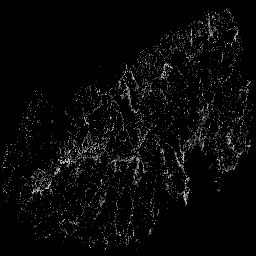

In [18]:
@run(scope='observation')
def __view(interpolator, /):
    rs, cs = interpolator.grid
    
    def decimate(
        arr: auto.numpy.ndarray,
        /,
        *,
        length: int,
    ) -> auto.numpy.ndarray:
        print(f'{len(arr)=!r}')
        stride = int(auto.math.floor( len(arr) / length ))
        arr = arr[::stride]
        arr = arr[:length]
        return arr
    
    rs = decimate(rs, length=256)
    cs = decimate(cs, length=256)
    
    grid = auto.numpy.hstack(tuple(
        v.reshape((-1, 1))
        for v in auto.numpy.meshgrid(
            rs,
            cs,
            indexing='ij',
        )
    ))
    assert grid.shape == (len(rs) * len(cs), 2)
    
    confidence = (interpolator(grid, method='linear') * 255.0 / 4.0).astype(auto.numpy.uint8)
    confidence = confidence.reshape((len(rs), len(cs)))
    
    image = auto.PIL.Image.fromarray(confidence, mode='L')
    
    auto.IPython.display.display(image)

r=3305001 c=2250075


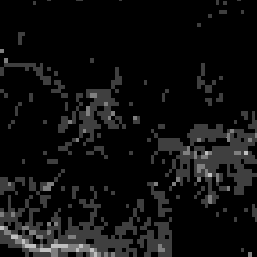

In [19]:
## @Tile.from_.register(Location)
@auto.mediocreatbest.doctest
def convert_location_to_tile(*, lat: Degree, lng: Degree, zoom: int, math=auto.math) -> tuple[int, int]:
    r"""
    
    >>> convert_location_to_tile(lat=35.6, lng=-83.52, zoom=11)
    (807, 548)
    >>> convert_location_to_tile(lat=35.0, lng=-84.5, zoom=15)
    (12979, 8692)
    >>> convert_location_to_tile(lat=36.25, lng=-82.5, zoom=15)
    (12839, 8874)
    
    """
    # Thanks https://stackoverflow.com/a/72476578
    
    #> lat_rad = math.radians(lat_deg)
    lat_rad = math.radians(lat)
    
    #> n = 2.0 ** zoom
    n = 2.0 ** zoom
    
    #> xtile = int((lon_deg + 180.0) / 360.0 * n)
    col = int((lng + 180.0) / 360.0 * n)
    
    #> ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    row = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    
    #> return (xtile, ytile)
    return row, col


@run(scope='observation')
def __view(interpolator, /):
    lat, lng = (
        (35.6201452, -83.4372325)  # Clingman's Dome
    )
    
    r, c = convert_location_to_tile(
        lat=lat,
        lng=lng,
        zoom=Tixel.z,
    )
    print(f'{r=!r} {c=!r}')
    
    k = 2
    rs = auto.numpy.arange(r-k*128, r+k*128+1, k)
    cs = auto.numpy.arange(c-k*128, c+k*128+1, k)
    
#     rs, cs = interpolator.grid
    
#     def decimate(
#         arr: auto.numpy.ndarray,
#         /,
#         *,
#         length: int,
#     ) -> auto.numpy.ndarray:
#         print(f'{len(arr)=!r}')
#         stride = int(auto.math.floor( len(arr) / length ))
#         arr = arr[::stride]
#         arr = arr[:length]
#         return arr
    
#     rs = decimate(rs, length=256)
#     cs = decimate(cs, length=256)
    
    grid = auto.numpy.hstack(tuple(
        v.reshape((-1, 1))
        for v in auto.numpy.meshgrid(
            rs,
            cs,
            indexing='ij',
        )
    ))
    assert grid.shape == (len(rs) * len(cs), 2)
    
    confidence = (interpolator(grid, method='linear').astype(auto.numpy.float32) * 255.0 / 4.0).astype(auto.numpy.uint8)
    confidence = confidence.reshape((len(rs), len(cs)))
    
    image = auto.PIL.Image.fromarray(confidence, mode='L')
    
    auto.IPython.display.display(image)
    

## Background

In [20]:
@run(after=auto.pprint.pp, scope='background')
def domain():
    from bs4 import BeautifulSoup
    
    soup = BeautifulSoup(r'''
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;">
        <img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -19px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/807@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 237px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/805@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, -275px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/548/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(439px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(695px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/547/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(183px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/550/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(951px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/546/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(-73px, 493px, 0px); opacity: 1;"><img alt="" role="presentation" src="https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/551/808@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg" class="leaflet-tile leaflet-tile-loaded" style="width: 256px; height: 256px; transform: translate3d(1207px, 493px, 0px); opacity: 1;">
    ''', 'html.parser')
    
    urls = []
    for img in soup('img'):
        src = img['src']
        url = TileURL.decode(src)
        urls.append(url)
    
    return Domain(
        lo=Coord(
            z=min(url.z for url in urls),
            x=min(url.x for url in urls),
            y=min(url.y for url in urls),
        ),
        hi=Coord(
            z=max(url.z for url in urls),
            x=max(url.x for url in urls),
            y=max(url.y for url in urls),
        ),
    )


Domain(lo=Coord(z=11, x=546, y=805), hi=Coord(z=11, x=551, y=808))


In [21]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Tile:
    coord: Coord
    url: str = auto.dataclasses.field(repr=False)
    image: bytes = auto.dataclasses.field(repr=False)

@run(scope='background', after=lambda x: print(len(x)))
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg"""
    )):
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)

        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))

    return tiles

Cache Hit: {url}: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1105.06it/s]

24


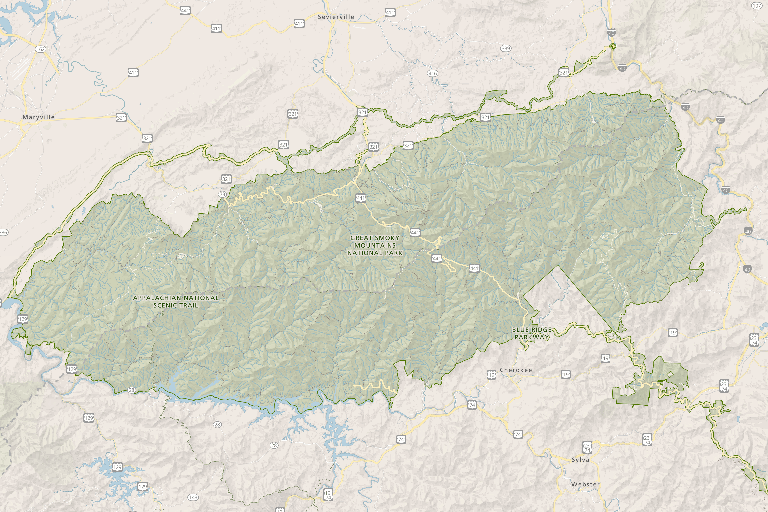

In [22]:
__stitch_tiles(run.g['background__tiles'])

In [23]:
@run(scope='background')
def interpolator(tiles, /):
    res = 512
    
    zs = sorted(set(tile.coord.z for tile in tiles))
    assert len(zs) == 1
    ys = sorted(set(tile.coord.y for tile in tiles))
    xs = sorted(set(tile.coord.x for tile in tiles))
    
    print(f"""{len(ys)=!r} {len(xs)=!r}""")
    
    # This is cursed.
    points = (
        2 ** (Tixel.z - auto.math.log2(res) - zs[0]) * (auto.numpy.repeat(res * auto.numpy.array(ys)[:, None], res, axis=1) + auto.numpy.arange(res)[None, :]).ravel(),
        2 ** (Tixel.z - auto.math.log2(res) - zs[0]) * (auto.numpy.repeat(res * auto.numpy.array(xs)[:, None], res, axis=1) + auto.numpy.arange(res)[None, :]).ravel(),
    )
    
    print(f"""ys: {points[0][[0, -1]]=!r}
xs: {points[1][[0, -1]]=!r}""")
    
    values = auto.numpy.zeros(
        shape=(len(points[0]), len(points[1]), 3),
        dtype=auto.numpy.float32,
    )
    print(f"""{values.shape=!r} {values.dtype=!r}""")

    for tile in tiles:
        yi = ys.index(tile.coord.y)
        xi = xs.index(tile.coord.x)
        
        with auto.io.BytesIO(tile.image) as f:
            image = auto.PIL.Image.open(f)
            image.load()
            
        image = image.convert('RGB')
        image = auto.numpy.array(image, dtype=auto.numpy.float32)
        assert image.shape == (res, res, 3), image.shape
        assert image.dtype == auto.numpy.float32
        assert 1.0 < image.max() <= 255.0
        
        image /= 255.0
        assert 0.0 < image.max() <= 1.0
        
#         import numpy.lib.recfunctions
#         image = auto.numpy.lib.recfunctions.unstructured_to_structured(
#             image,
#             dtype=values.dtype,
#         )
#         assert image.shape == (res, res), \
#             f"""Wrong shape: {image.shape=!r}"""
#         assert image.dtype == values.dtype
        
        values[
            slice(
                (yi+0)*res,
                (yi+1)*res,
            ),
            slice(
                (xi+0)*res,
                (xi+1)*res,
            ),
        ] = image
               
    
    return auto.scipy.interpolate.RegularGridInterpolator(
        points,
        values,
    )

len(ys)=4 len(xs)=6
ys: points[0][[0, -1]]=ndarray(array([3297280., 3313656.]), shape=(2,), dtype=dtype('float64'))
xs: points[1][[0, -1]]=ndarray(array([2236416., 2260984.]), shape=(2,), dtype=dtype('float64'))
values.shape=(2048, 3072, 3) values.dtype=dtype('float32')


## Elevation

In [24]:
@run(scope='elevation', after=print)
def domain():
    return Domain(
        lo=Coord(z=11, x=546-1, y=805-1),
        hi=Coord(z=11, x=551+1, y=808+1),
    )

@run(scope='elevation')
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/14/3826/6127@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
    )) -> URL:
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)
        
        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))
    
    return tiles

Domain(lo=Coord(z=11, x=545, y=804), hi=Coord(z=11, x=552, y=809))


Cache Hit: {url}: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:00<00:00, 1222.17it/s]


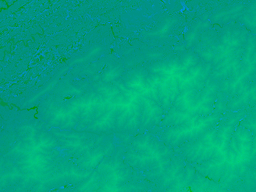

In [25]:
__stitch_tiles(auto.mediocreatbest.g['elevation__tiles'], size=32)

In [26]:
@run(scope='elevation')
def interpolator(tiles, /):
    res = 512
    
    def tile_altitude(tile: Tile, /) -> auto.numpy.NDArray[auto.numpy.float32]:
        with auto.io.BytesIO(tile.image) as f:
            image = auto.PIL.Image.open(f)
            image.load()
        
        image = image.convert('RGB')
        
        rgb = auto.numpy.array(image)
        assert len(rgb.shape) == 3, \
            f"""Expected dimension 3: {rgb.shape=!r}"""
        assert rgb.shape[0] == rgb.shape[1], \
            f"""Expected square image: {rgb.shape=!r}"""
        assert rgb.shape[0] == res, \
            f"""Expected resolution: {res}; Got resolution: {rgb.shape[0]}"""
        assert rgb.shape[2] == 3, \
            f"""Expected last component to be rgb values: {rgb.shape=!r}"""
        assert rgb.dtype == auto.numpy.uint8, \
            f"""Expected dtype to be uint8_t: {rgb.dtype=!r}"""
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        #> elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        altitude = auto.numpy.zeros(
            shape=(rgb.shape[0], rgb.shape[1]),
            dtype=auto.numpy.float32,
        )
        
        altitude += rgb[:, :, 0] * (1 * 256 * 256)
        altitude += rgb[:, :, 1] * (1 * 256)
        altitude += rgb[:, :, 2] * (1)
        altitude *= 0.1
        altitude -= 10000
        
        return altitude

    xs = sorted(set(tile.coord.x for tile in tiles))
    ys = sorted(set(tile.coord.y for tile in tiles))
    zs = sorted(set(tile.coord.z for tile in tiles))
    
    assert len(zs) == 1
    z ,= zs
    
    print(f'{z=!r}')
    
    dz = int(auto.math.log2(res))
    print(f'{dz=!r} {res=!r}')
    points = (
        auto.numpy.arange(
            (min(ys) + 0) * 2 ** dz,
            (max(ys) + 1) * 2 ** dz,
        ),
        auto.numpy.arange(
            (min(xs) + 0) * 2 ** dz,
            (max(xs) + 1) * 2 ** dz,
        ),
    )
    z += dz
    print(f'{z=!r}')
    
    print(f'{points[0][0]=!r}')
    print(f'{points[0][-1]=!r}')
    
    if z < Tixel.z:
        dz = Tixel.z - z
        print(f'{dz=!r}')
        points = (
            points[0] * 2 ** dz,
            points[1] * 2 ** dz,
        )
        z += dz
        print(f'{z=!r}')
        
        print(f'{points[0][0]=!r}')
        print(f'{points[0][-1]=!r}')
    
    assert z == Tixel.z
    
    values = auto.numpy.zeros(
        shape=(
            len(ys)*res,
            len(xs)*res,
        ),
        dtype=auto.numpy.float32,
    )
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        values[
            slice(
                (yi + 0) * res,
                (yi + 1) * res,
            ),
            slice(
                (xi + 0) * res,
                (xi + 1) * res,
            ),
        ] = tile_altitude(tile)

    return auto.scipy.interpolate.RegularGridInterpolator(
        points=points,
        values=values,
    )

z=11
dz=9 res=512
z=20
points[0][0]=411648
points[0][-1]=414719
dz=3
z=23
points[0][0]=3293184
points[0][-1]=3317752


In [27]:
auto.mediocreatbest.g['elevation__interpolator']([
    auto.mediocreatbest.g['elevation__interpolator'].grid[0][100],
    auto.mediocreatbest.g['elevation__interpolator'].grid[1][100],
], method='quintic')

ndarray(array([256.9004], dtype=float32), shape=(1,), dtype=dtype('float32'))

## OSPRay

### Config

In [28]:
@run(scope='ospray')
def version():
    return (
        '2.12.0'
    )

### Download

In [29]:
@run(scope='ospray')
def tarball(version, /) -> auto.pathlib.Path:
    # Thanks https://stackoverflow.com/a/44378512
    #> from urllib.request import urlretrieve

    #> url = 'http://mirror.pnl.gov/releases/16.04.2/ubuntu-16.04.2-desktop-amd64.iso'
    src = f"""https://github.com/ospray/ospray/releases/download/v{version}/ospray-{version}.x86_64.linux.tar.gz"""
    
    #> dst = 'ubuntu-16.04.2-desktop-amd64.iso'
    dst = auto.pathlib.Path.cwd() / 'tmp' / f"""ospray-{version}.tar.gz"""
    
    #> urlretrieve(url, dst)
    if not dst.exists():
        print(f"""Download {src} to {dst}""")
        auto.urllib.request.urlretrieve(src, str(dst))
    
    else:
        print(f"""Already downloaded to {dst}""")
    
    return dst

Already downloaded to /home/thobson2/src/Sunrise-Demo/tmp/ospray-2.12.0.tar.gz


### Extract

In [30]:
@run(scope='ospray')
def prefix(version, tarball: Path, /) -> auto.pathlib.Path:
    src = tarball
    dst = auto.pathlib.Path.cwd() / 'tmp' / f"""ospray-{version}"""
    
    if dst.exists():
        print(f"""Already extracted {src} to {dst}""")
    
    else:
        with auto.tempfile.TemporaryDirectory() as tmp:
            print(f"""Extract {src} to {tmp}""")
            tmp = auto.pathlib.Path(tmp)
            
            with auto.tarfile.open(src, 'r') as tar:
                tar.extractall(tmp)

            src = tmp / f"""ospray-{version}.x86_64.linux"""
            print(f"""Move {src} to {dst}""")
            auto.shutil.move(src, dst)
    
    return dst

Already extracted /home/thobson2/src/Sunrise-Demo/tmp/ospray-2.12.0.tar.gz to /home/thobson2/src/Sunrise-Demo/tmp/ospray-2.12.0


### Load

In [31]:
@run(scope='ospray', once=True)
def lib(prefix: Path, /):
    return auto.ctypes.CDLL(
        name=(
            prefix / 'lib' / 'libospray.so'
        ),
        mode=auto.os.RTLD_LOCAL | auto.os.RTLD_DEEPBIND,
    )

### Init

In [32]:
@run(scope='ospray', once=True)
def __init(lib, /):
    lib.ospInit.argtypes = [
        auto.ctypes.POINTER(auto.ctypes.c_int),
        auto.ctypes.POINTER(auto.ctypes.c_char_p),
    ]
    lib.ospInit.restype = auto.ctypes.c_uint32
    
    error = lib.ospInit(None, None)
    assert error == 0, \
        f"""Error during ospInit: {error=!r}"""

### Definitions

In [146]:
@run(scope='ospray')
def __definitions(lib, /):
    if not hasattr(lib, 'OSPObject'):
        lib.OSPObject = auto.ctypes.POINTER(type('OSPObject', (auto.ctypes.Structure,), {
            '_fields': [],
        }))
    
    for name in auto.re.findall(r'\w+', r'''
        *OSPCamera, *OSPData, OSPFrameBuffer, *OSPFuture, *OSPGeometricModel,
        **OSPGeometry, *OSPGroup, OSPImageOperation, *OSPInstance, *OSPLight,
        **OSPMaterial, *, OSPRenderer, *OSPTexture,
        **OSPTransferFunction, *OSPVolume, OSPVolumetricModel, *OSPWorld;
    '''):
#         setattr(lib, name, auto.ctypes.POINTER(type(name, (OSPObject,), {
#             '_fields_': [],
#         })))
        setattr(lib, name, lib.OSPObject)
    
    lib.OSPError = type('OSPError', (auto.ctypes.c_uint32,), dict(
        OSP_NO_ERROR=0,  # no error occurred
        OSP_UNKNOWN_ERROR=1,  # an unknown error occurred
        OSP_INVALID_ARGUMENT=2,  # an invalid argument was specified
        OSP_INVALID_OPERATION=3,  # the operation is not allowed for the specified object
        OSP_OUT_OF_MEMORY=4,  # there is not enough memory to execute the command
        OSP_UNSUPPORTED_CPU=5,  # the CPU is not supported (minimum ISA is SSE4.1 on x86_64 and NEON on ARM64)
        OSP_VERSION_MISMATCH=6,  # a module could not be loaded due to mismatching version
    ))
    
    lib.OSPDataType = auto.ctypes.c_uint32
    lib.OSPFrameBufferFormat = auto.ctypes.c_uint32
    lib.OSPFrameBufferChannel = auto.ctypes.c_uint32
    lib.OSPTextureFormat = auto.ctypes.c_uint32
    lib.OSPTextureFilter = auto.ctypes.c_uint32
    for name, value in dict(
        # highest bit to represent objects/handles
        OSP_OBJECT = 0x8000000,

        # object subtypes
        OSP_DATA = 0x8000000 + 100 + 0,
        OSP_CAMERA = 0x8000000 + 100 + 1,
        OSP_FRAMEBUFFER = 0x8000000 + 100 + 2,
        OSP_FUTURE = 0x8000000 + 100 + 3,
        OSP_GEOMETRIC_MODEL = 0x8000000 + 100 + 4,
        OSP_GEOMETRY = 0x8000000 + 100 + 5,
        OSP_GROUP = 0x8000000 + 100 + 6,
        OSP_IMAGE_OPERATION = 0x8000000 + 100 + 7,
        OSP_INSTANCE = 0x8000000 + 100 + 8,
        OSP_LIGHT = 0x8000000 + 100 + 9,
        OSP_MATERIAL = 0x8000000 + 100 + 10,
        OSP_RENDERER = 0x8000000 + 100 + 11,
        OSP_TEXTURE = 0x8000000 + 100 + 12,
        OSP_TRANSFER_FUNCTION = 0x8000000 + 100 + 13,
        OSP_VOLUME = 0x8000000 + 100 + 14,
        OSP_VOLUMETRIC_MODEL = 0x8000000 + 100 + 15,
        OSP_WORLD = 0x8000000 + 100 + 16,
        
        OSP_UCHAR = 2500,
        OSP_VEC2UC = 2501,
        OSP_VEC3UC = 2502,
        OSP_VEC4UC = 2503,
        
        OSP_VEC4UI = 4500 + 3,
        OSP_VEC2F = 6000 + 1,
        OSP_VEC3F = 6000 + 2,
        OSP_VEC4F = 6000 + 3,
        
        OSP_LINEAR2F = 12000 + 0,
        OSP_LINEAR3F = 12000 + 1,
        OSP_AFFINE2F = 12000 + 2,
        OSP_AFFINE3F = 12000 + 3,
        
        OSP_FB_NONE = 0,
        OSP_FB_RGBA8 = 1,
        OSP_FB_SRGBA = 2,
        OSP_FB_RGBA32F = 3,
        
        OSP_FB_COLOR = 1 << 0,
        OSP_FB_DEPTH = 1 << 1,
        OSP_FB_ACCUM = 1 << 2,
        OSP_FB_VARIANCE = 1 << 3,
        
        OSP_TEXTURE_RGBA8 = 0,
        OSP_TEXTURE_SRGBA = 1,
        OSP_TEXTURE_RGBA32F = 2,
        OSP_TEXTURE_RGB8 = 3,
        OSP_TEXTURE_SRGB = 4,
        OSP_TEXTURE_RGB32F = 5,
        OSP_TEXTURE_R8 = 6,
        OSP_TEXTURE_R32F = 7,
        OSP_TEXTURE_L8 = 8,
        OSP_TEXTURE_RA8 = 9,
        OSP_TEXTURE_LA8 = 10,
        OSP_TEXTURE_RGBA16 = 11,
        OSP_TEXTURE_RGB16 = 12,
        OSP_TEXTURE_RA16 = 13,
        OSP_TEXTURE_R16 = 14,
        
        OSP_TEXTURE_FILTER_BILINEAR = 0,
        OSP_TEXTURE_FILTER_NEAREST = 1,
    ).items():
        setattr(lib, name, value)
    
    lib.ospInit.argtypes = [
        auto.ctypes.POINTER(auto.ctypes.c_int),
        auto.ctypes.POINTER(auto.ctypes.c_char_p),
    ]
    lib.ospInit.restype = lib.OSPError
    
    lib.ospCommit.argtypes = [lib.OSPObject]
    lib.ospCommit.restype = None
    
    lib.ospRetain.argtypes = [lib.OSPObject]
    lib.ospRetain.restype = None
    
    lib.ospRelease.argtypes = [lib.OSPObject]
    lib.ospRelease.restype = None
    
    lib.ospSetParam.argtypes = [lib.OSPObject, auto.ctypes.c_char_p, lib.OSPDataType, auto.ctypes.c_void_p]
    lib.ospSetParam.restype = None
    
    
    #--- Data
    
    lib.ospNewSharedData.argtypes = [
        auto.ctypes.c_void_p,
        lib.OSPDataType,
        auto.ctypes.c_uint64, auto.ctypes.c_int64,
        auto.ctypes.c_uint64, auto.ctypes.c_int64,
        auto.ctypes.c_uint64, auto.ctypes.c_int64,
    ]
    lib.ospNewSharedData.restype = lib.OSPData
    
    lib.ospNewData.argtypes = [
        lib.OSPDataType,
        auto.ctypes.c_uint64,
        auto.ctypes.c_uint64,
        auto.ctypes.c_uint64,
    ]
    lib.ospNewData.restype = lib.OSPData
    
    lib.ospCopyData.argtypes = [
        lib.OSPData,
        lib.OSPData,
        auto.ctypes.c_uint64,
        auto.ctypes.c_uint64,
        auto.ctypes.c_uint64,
    ]
    lib.ospCopyData.restype = None
    
    
    #--- Constructors
    
    lib.ospNewWorld.argtypes = []
    lib.ospNewWorld.restype = lib.OSPWorld
    
    lib.ospNewInstance.argtypes = [lib.OSPGroup]
    lib.ospNewInstance.restype = lib.OSPInstance
    
    lib.ospNewGroup.argtypes = []
    lib.ospNewGroup.restype = lib.OSPGroup
    
    lib.ospNewGeometricModel.argtypes = [lib.OSPGeometry]
    lib.ospNewGeometricModel.restype = lib.OSPGeometricModel
    
    lib.ospNewGeometry.argtypes = [auto.ctypes.c_char_p]
    lib.ospNewGeometry.restype = lib.OSPGeometry
    
    lib.ospNewMaterial.argtypes = [auto.ctypes.c_void_p, auto.ctypes.c_char_p]
    lib.ospNewMaterial.restype = lib.OSPMaterial
    
    lib.ospNewRenderer.argtypes = [auto.ctypes.c_char_p]
    lib.ospNewRenderer.restype = lib.OSPRenderer
    
    lib.ospNewCamera.argtypes = [auto.ctypes.c_char_p]
    lib.ospNewCamera.restype = lib.OSPCamera
    
    lib.ospNewTexture.argtypes = [auto.ctypes.c_char_p]
    lib.ospNewTexture.restype = lib.OSPTexture
    
    lib.ospNewFrameBuffer.argtypes = [
        auto.ctypes.c_int, auto.ctypes.c_int,
        lib.OSPFrameBufferFormat,
        lib.OSPFrameBufferChannel,
    ]
    lib.ospNewFrameBuffer.restype = lib.OSPFrameBuffer
    
    lib.ospMapFrameBuffer.argtypes = [lib.OSPFrameBuffer, lib.OSPFrameBufferChannel]
    lib.ospMapFrameBuffer.restype = auto.ctypes.c_void_p
    
    lib.ospUnmapFrameBuffer.argtypes = [auto.ctypes.c_void_p, lib.OSPFrameBuffer]
    lib.ospUnmapFrameBuffer.restype = None
    
    lib.OSPBounds = type('OSPBounds', (auto.ctypes.Structure,), {
        '_fields_': [
            ('xlo', auto.ctypes.c_float),
            ('ylo', auto.ctypes.c_float),
            ('zlo', auto.ctypes.c_float),
            ('xhi', auto.ctypes.c_float),
            ('yhi', auto.ctypes.c_float),
            ('zhi', auto.ctypes.c_float),
        ],
    })
        
    lib.ospGetBounds.argtypes = [lib.OSPObject]
    lib.ospGetBounds.restype = lib.OSPBounds
    
    
    #--- Utilities

    lib.ospNewSharedData1D.argtypes = [
        auto.ctypes.c_void_p, lib.OSPDataType,
        auto.ctypes.c_uint64,
    ]
    lib.ospNewSharedData1D.restype = lib.OSPData
    
    lib.ospNewSharedData2D.argtypes = [
        auto.ctypes.c_void_p, lib.OSPDataType,
        auto.ctypes.c_uint64, auto.ctypes.c_uint64,
    ]
    lib.ospNewSharedData2D.restype = lib.OSPData
    
    lib.ospNewSharedData3D.argtypes = [
        auto.ctypes.c_void_p, lib.OSPDataType,
        auto.ctypes.c_uint64, auto.ctypes.c_uint64, auto.ctypes.c_uint64,
    ]
    lib.ospNewSharedData3D.restype = lib.OSPData
    
    
    lib.ospNewData1D.argtypes = [
        lib.OSPDataType,
        auto.ctypes.c_uint64,
    ]
    lib.ospNewData1D.restype = lib.OSPData
    
    lib.ospNewData2D.argtypes = [
        lib.OSPDataType,
        auto.ctypes.c_uint64, auto.ctypes.c_uint64,
    ]
    lib.ospNewData2D.restype = lib.OSPData
    
    
    lib.ospCopyData1D.argtypes = [
        lib.OSPData, lib.OSPData,
        auto.ctypes.c_uint64,
    ]
    lib.ospCopyData1D.restype = None
    
    lib.ospCopyData2D.argtypes = [
        lib.OSPData, lib.OSPData,
        auto.ctypes.c_uint64, auto.ctypes.c_uint64,
    ]
    lib.ospCopyData2D.restype = None
    
    
    def __define_setter(suffix: str, /, *argtypes: list, n=1):
        assert len(argtypes) > 0
        getattr(lib, f'ospSet{suffix}').argtypes = [
            lib.OSPObject, auto.ctypes.c_char_p,
            *(argtypes * n),
        ]
        getattr(lib, f'ospSet{suffix}').restype = None
        
    __define_setter('String', auto.ctypes.c_char_p)
    __define_setter('Object', lib.OSPObject)
    
    __define_setter('Bool', auto.ctypes.c_int)
    __define_setter('Float', auto.ctypes.c_float)
    __define_setter('Int', auto.ctypes.c_int)
    
    __define_setter('Vec2f', auto.ctypes.c_float, n=2)
    __define_setter('Vec3f', auto.ctypes.c_float, n=3)
    __define_setter('Vec4f', auto.ctypes.c_float, n=4)
    
    __define_setter('Vec2i', auto.ctypes.c_int, n=2)
    __define_setter('Vec3i', auto.ctypes.c_int, n=3)
    __define_setter('Vec4i', auto.ctypes.c_int, n=4)
    
    lib.ospSetObjectAsData.argtypes = [
        lib.OSPObject, auto.ctypes.c_char_p,
        lib.OSPDataType, lib.OSPObject,
    ]
    
    
    lib.ospRenderFrameBlocking.argtypes = [lib.OSPFrameBuffer, lib.OSPRenderer, lib.OSPCamera, lib.OSPWorld]
    lib.ospRenderFrameBlocking.restype = auto.ctypes.c_float
    

## Render

In [34]:
@run(scope='render', after=print)
def lib(ospray__lib, /):
    return ospray__lib

<CDLL '/home/thobson2/src/Sunrise-Demo/tmp/ospray-2.12.0/lib/libospray.so', handle 5599153f55e0 at 0x7efc7ffdea70>


### Terrain (OSPGeometry)

In [35]:
@run(scope='render', after=print)
def terrain(lib, elevation__interpolator, /):
    """mesh/OSPGeometry:mesh:position/vertex.position:vec3f[]+index/index:vec4ui[]"""
    rlo, rhi = 3299840, 3310591
    clo, chi = 2236928, 2259455
    rs = auto.numpy.arange(rlo, rhi)
    cs = auto.numpy.arange(clo, chi)

    def decimate(
        rs: auto.np.ndarray,
        cs: auto.np.ndarray,
        /,
        *,
        duration: 'seconds',
        rate: 'item/s',
    ) -> tuple[auto.np.ndarray, auto.np.ndarray]:
        total_items = len(rs) * len(cs)

        actual_items = duration * rate
    #             print(f'{items = } = {duration} * {rate}')

        factor_items = total_items / actual_items

        stride = int(auto.math.ceil(auto.math.sqrt( factor_items )))

    #             stride = int(auto.math.ceil())
    #             print(f'{stride = } = int(auto.math.ceil( {len(rs)} / {items} == {len(rs)/items} ))')

        rs = rs[::stride]
        cs = cs[::stride]

        print(f'Decimate by factor of {stride}**2={stride**2 :,d} from {total_items :,d} to {len(rs)*len(cs) :,d} vertices')
        return rs, cs

    rs, cs = decimate(
        rs, cs,
        duration=(
#             1  # low resolution
            10  # medium resolution
        ),
        rate=6260094,
    )

    position: 'OSPGeometry:mesh:vertex.position:vec3f[]' = auto.numpy.zeros(
        shape=(len(rs), len(cs)),
        dtype=[
            ('x', 'f4'),
            ('y', 'f4'),
            ('z', 'f4'),
        ],
    )
    
    texcoord: 'OSPGeometry:mesh:vertex.texcoord:vec2f[]' = auto.numpy.zeros(
        shape=(len(rs), len(cs)),
        dtype=[
            ('u', 'f4'),
            ('v', 'f4'),
        ],
    )
    
    @auto.mediocreatbest.immediate
    def __vert():
        with auto.tqdm.auto.tqdm(total=position.size, unit='vert') as tqdm:
            for ri, r in enumerate(rs):
                lats, lngs = convert_tile_coordinates_to_latlng(
                    z=Tixel.z,
                    y=r,
                    x=cs,
                    math=auto.numpy,
                )

                grid = auto.numpy.hstack(tuple(
                    v.reshape((-1, 1))
                    for v in auto.numpy.meshgrid(
                        [r],
                        cs,
                        indexing='ij',
                    )
                ))
                assert grid.shape == (len(cs), 2), \
                    f"""Wrong shape: {grid.shape=!r}"""

                alts = elevation__interpolator(
                    grid,
                    method='linear',
                )
                assert alts.shape == (len(cs),), \
                    f"""Wrong shape: {alts.shape=!r}"""

                xs, ys, zs = convert_location_to_spatial(
                    lat=lats,
                    lng=lngs,
                    alt=alts,
                    math=auto.numpy,
                )
                xs, ys, zs = (v/1000.0 for v in [xs, ys, zs])
                assert xs.shape == (len(cs),), \
                    f"""Wrong shape: {xs.shape=!r}"""

                position[ri, :]['x'] = xs
                position[ri, :]['y'] = ys
                position[ri, :]['z'] = zs
                
                us = auto.numpy.linspace(0.0, 1.0, num=len(cs))
                vs = ri / len(rs)
                
                texcoord[ri, :]['u'] = us
                texcoord[ri, :]['v'] = vs

                tqdm.update(len(cs))

    print(f'{position["x"].min()=!r} ;; {position["x"].max()=!r}')
    print(f'{position["y"].min()=!r} ;; {position["y"].max()=!r}')
    print(f'{position["z"].min()=!r} ;; {position["z"].max()=!r}')

    print(f'{texcoord["u"].min()=!r} ;; {texcoord["u"].max()=!r}')
    print(f'{texcoord["v"].min()=!r} ;; {texcoord["v"].max()=!r}')

    # index = OSPGeometry:mesh:index:vec4ui[]
    index = auto.numpy.zeros(
        shape=(len(rs)-1, len(cs)-1),
        dtype=[
            ('a', 'u4'),
            ('b', 'u4'),
            ('c', 'u4'),
            ('d', 'u4'),
        ],
    )

    @auto.mediocreatbest.immediate
    def __face():
        def indexof(ri: int, ci: int, /) -> int:
            return ri * len(cs) + ci

        with auto.tqdm.auto.tqdm(total=index.size, unit='face') as tqdm:
            # a -1- b
            # |     |
            # 4     2
            # |     |
            # d -3- c

            for ri in range(0, len(rs)-1):
                cis = auto.numpy.arange(len(cs)-1, dtype='u4')

                a = indexof(ri+0, cis+0)
                b = indexof(ri+0, cis+1)
                c = indexof(ri+1, cis+1)
                d = indexof(ri+1, cis+0)

                index[ri, :]['a'] = a
                index[ri, :]['b'] = b
                index[ri, :]['c'] = c
                index[ri, :]['d'] = d
                tqdm.update(len(cis))

        return index

    print(f'{index["a"].min()=!r} ;; {index["a"].max()=!r}')
    print(f'{index["b"].min()=!r} ;; {index["b"].max()=!r}')
    print(f'{index["c"].min()=!r} ;; {index["c"].max()=!r}')
    print(f'{index["d"].min()=!r} ;; {index["d"].max()=!r}')

    terrain = lib.ospNewGeometry(b'mesh')
    
    @auto.mediocreatbest.immediate
    def position():
        dst = lib.ospNewData1D(lib.OSP_VEC3F, position.size)
        src = lib.ospNewSharedData1D(position.ctypes.data, lib.OSP_VEC3F, position.size)
        lib.ospCommit(src)
        lib.ospCopyData1D(src, dst, 0)
        lib.ospCommit(dst)
        lib.ospRelease(src)
        return dst
    lib.ospSetObject(terrain, b'vertex.position', position)
    
    @auto.mediocreatbest.immediate
    def texcoord():
        dst = lib.ospNewData1D(lib.OSP_VEC2F, texcoord.size)
        src = lib.ospNewSharedData1D(texcoord.ctypes.data, lib.OSP_VEC2F, texcoord.size)
        lib.ospCommit(src)
        lib.ospCopyData1D(src, dst, 0)
        lib.ospCommit(dst)
        lib.ospRelease(src)
        return dst
    lib.ospSetObject(terrain, b'vertex.texcoord', texcoord)
    
    @auto.mediocreatbest.immediate
    def index():
        dst = lib.ospNewData1D(lib.OSP_VEC4UI, index.size)
        src = lib.ospNewSharedData1D(index.ctypes.data, lib.OSP_VEC4UI, index.size)
        lib.ospCommit(src)
        lib.ospCopyData1D(src, dst, 0)
        lib.ospCommit(dst)
        lib.ospRelease(src)
        return dst
    lib.ospSetObject(terrain, b'index', index)
    
    lib.ospCommit(terrain)
    return terrain
    

Decimate by factor of 2**2=4 from 242,187,777 to 60,555,264 vertices


  0%|          | 0/60555264 [00:00<?, ?vert/s]

position["x"].min()=540.02075 ;; position["x"].max()=629.7047
position["y"].min()=3693.0999 ;; position["y"].max()=3727.3823
position["z"].min()=-5163.7104 ;; position["z"].max()=-5129.842
texcoord["u"].min()=0.0 ;; texcoord["u"].max()=1.0
texcoord["v"].min()=0.0 ;; texcoord["v"].max()=0.999814


  0%|          | 0/60538625 [00:00<?, ?face/s]

index["a"].min()=0 ;; index["a"].max()=60543998
index["b"].min()=1 ;; index["b"].max()=60543999
index["c"].min()=11265 ;; index["c"].max()=60555263
index["d"].min()=11264 ;; index["d"].max()=60555262


### Colormap (OSPMaterial[])

In [36]:
@run(scope='render', after=print)
def colormap(lib, background__interpolator, /):
    def Data(array: auto.numpy.ndarray, /, *, type: lib.OSPDataType) -> lib.OSPData:
        if len(array.shape) == 0:
            array = array[None, None, None]

        elif len(array.shape) == 1:
            array = array[:, None, None]

        elif len(array.shape) == 2:
            array = array[:, :, None]
            
        elif len(array.shape) == 3:
            array = array[:, :, :]

        else:
            raise NotImplementedError()

        src = lib.ospNewSharedData(
            array.ctypes.data, type,
            array.shape[0], array.strides[0],
            array.shape[1], array.strides[1],
            array.shape[2], array.strides[2],
        )
        lib.ospCommit(src)

        dst = lib.ospNewData(type, *array.shape)
        lib.ospCopyData(src, dst, 0, 0, 0)
        lib.ospCommit(dst)

        lib.ospRelease(src)
        return dst

    # Thanks https://species.atlasofthesmokies.org/style.css
    pinks = auto.numpy.array([
        # Black, obviously.
        # Represents 0-25%
        [0, 0, 0],

        #> #legend-pink-50 { background-color: #f069a3; }
        # Represents 25-50%
        [247, 105, 164],

        #> #legend-pink-75 { background-color: #c31d8e; }
        # Represents 50-75%
        [196, 28, 142],

        #> #legend-pink-100 { background-color: #752879; }
        # Represents 75-100%
        [121, 0, 124],
    ], dtype=auto.numpy.uint8)

    rlo, rhi = 3297280, 3313656
    clo, chi = 2236928, 2259455
    rs = auto.numpy.linspace(rlo, rhi, num=1024 * 4)
    rs = rs[::-1]  # Flip Y
    cs = auto.numpy.linspace(clo, chi, num=2048 * 4)
    
    @auto.mediocreatbest.immediate
    @auto.mediocreatbest.coroutine
    def display():
        handle = auto.IPython.display.display(None, display_id=True)
        
        while True:
            obj = yield
            handle.update(obj)
    
    def Colormap(pi: int, /) -> lib.OSPTexture:
        rgb = auto.numpy.zeros(
            shape=(len(rs), len(cs)),
            dtype=[
                ('r', 'f4'),
                ('g', 'f4'),
                ('b', 'f4'),
            ],
        )
        
        for ri, r in enumerate(rs):
            grid = auto.numpy.hstack(tuple(
                v.reshape((-1, 1))
                for v in auto.numpy.meshgrid(
                    [r],
                    cs,
                    indexing='ij',
                )
            ))
            assert grid.shape == (len(cs), 2), \
                f"""Wrong shape: {grid.shape=!r}"""
#             print(f"""{grid[:, 0].min()=!r} ;; {grid[:, 0].max()=!r}
# {grid[:, 1].min()=!r} ;; {grid[:, 1].max()=!r}""")
            
            rgbs = background__interpolator(
                grid,
                method='linear',
            )
            assert rgbs.shape == (len(cs), 3), \
                f"""Wrong shape: {rgbs.shape=!r}"""
            
            def composite(background: 'RGB', foreground: 'RGB', *, alpha: float):
                return background * (1.0 - alpha) + foreground * alpha
            
            pink = pinks[None, pi, :]
            pink = pink.astype(auto.numpy.float32)
            pink /= 255.0
            
            if pi == 0:
                alpha = 0.0
            else:
                alpha = 0.5
            
            rgbs = composite(rgbs, pink, alpha=alpha)
            assert rgbs.shape == (len(cs), 3), \
                f"""Wrong shape: {rgbs.shape=!r}"""
            
            rgb['r'][ri, :] = rgbs[:, 0]
            rgb['g'][ri, :] = rgbs[:, 1]
            rgb['b'][ri, :] = rgbs[:, 2]

#         import numpy.lib.recfunctions
#         display.send(auto.PIL.Image.fromarray(
#             (255.0 * auto.numpy.lib.recfunctions.structured_to_unstructured(rgb)).astype(auto.numpy.uint8),
#             mode='RGB',
#         ))
        
        data = Data(rgb, type=lib.OSP_VEC3F)
        
        texture = lib.ospNewTexture(b'texture2d')
        lib.ospSetInt(texture, b'format', lib.OSP_TEXTURE_RGB32F)
        lib.ospSetObject(texture, b'data', data)
        lib.ospCommit(texture)
        
        return texture

    materials: 'OSPMaterial[]' = auto.numpy.zeros(
        shape=(len(pinks),),
        dtype=auto.numpy.uintp,
    )
    
    for pi in range(len(pinks)):
        map_kd: lib.OSPTexture = Colormap(pi)
        
        material = lib.ospNewMaterial(None, b'obj')
        lib.ospSetObject(material, b'map_kd', map_kd)
        lib.ospCommit(material)
    
        materials[pi] = auto.ctypes.cast(material, auto.ctypes.c_void_p).value
    
    materials = Data(materials, type=lib.OSP_MATERIAL)
    
    return materials
    

None

### Observation (uint[8])

In [37]:
@run(scope='render', after=print)
def observation(lib, observation__interpolator, /) -> 'uint8[]':
    """OSPGeometricModel::index:uint8[]"""
    
    def Data(array: auto.numpy.ndarray, /, *, type: lib.OSPDataType) -> lib.OSPData:
        if len(array.shape) == 0:
            array = array[None, None, None]

        elif len(array.shape) == 1:
            array = array[:, None, None]

        elif len(array.shape) == 2:
            array = array[:, :, None]
            
        elif len(array.shape) == 3:
            array = array[:, :, :]

        else:
            raise NotImplementedError()

        src = lib.ospNewSharedData(
            array.ctypes.data, type,
            array.shape[0], array.strides[0],
            array.shape[1], array.strides[1],
            array.shape[2], array.strides[2],
        )
        lib.ospCommit(src)

        dst = lib.ospNewData(type, *array.shape)
        lib.ospCopyData(src, dst, 0, 0, 0)
        lib.ospCommit(dst)

        lib.ospRelease(src)
        return dst
    
    rlo, rhi = 3299840, 3310591
    clo, chi = 2236928, 2259455
    rs = auto.numpy.arange(rlo, rhi)
    cs = auto.numpy.arange(clo, chi)

    def decimate(
        rs: auto.np.ndarray,
        cs: auto.np.ndarray,
        /,
        *,
        duration: 'seconds',
        rate: 'item/s',
    ) -> tuple[auto.np.ndarray, auto.np.ndarray]:
        total_items = len(rs) * len(cs)

        actual_items = duration * rate
    #             print(f'{items = } = {duration} * {rate}')

        factor_items = total_items / actual_items

        stride = int(auto.math.ceil(auto.math.sqrt( factor_items )))

    #             stride = int(auto.math.ceil())
    #             print(f'{stride = } = int(auto.math.ceil( {len(rs)} / {items} == {len(rs)/items} ))')

        rs = rs[::stride]
        cs = cs[::stride]

        print(f'Decimate by factor of {stride}**2={stride**2 :,d} from {total_items :,d} to {len(rs)*len(cs) :,d} vertices')
        return rs, cs

    rs, cs = decimate(
        rs, cs,
        duration=(
#             1  # low resolution
            10  # medium resolution
        ),
        rate=6260094,
    )
    
    index = auto.numpy.zeros(
        shape=(len(rs), len(cs)),
        dtype='u1',
    )
    
    for (ri, r) in enumerate(rs):
        grid = auto.numpy.hstack(tuple(
            v.reshape((-1, 1))
            for v in auto.numpy.meshgrid(
                [r],
                cs,
                indexing='ij',
            )
        ))
        assert grid.shape == (len(cs), 2), \
            f"""Wrong shape: {grid.shape=!r}"""
#             print(f"""{grid[:, 0].min()=!r} ;; {grid[:, 0].max()=!r}
# {grid[:, 1].min()=!r} ;; {grid[:, 1].max()=!r}""")
        
        category = observation__interpolator(
            grid,
            method='nearest',
        )
        assert category.shape == (len(cs),), \
            f"""Wrong shape: {category.shape=!r}"""
        assert auto.numpy.all((0 <= category) & (category < 4))
        
        index[ri, :] = category
    
    index = index.reshape((-1,))
    
    print(auto.collections.Counter(index.flat))
    
    index = Data(index, type=lib.OSP_UCHAR)
    return index
    

Decimate by factor of 2**2=4 from 242,187,777 to 60,555,264 vertices
Counter({0: 54873340, 1: 4270178, 2: 1167187, 3: 244559})


In [38]:
@run(scope='render', after=print)
def world(lib, terrain, colormap, observation, /):
    with auto.contextlib.ExitStack() as stack:
        enter = stack.enter_context
        defer = stack.callback
        
        # model/OSPGeometricModel::geometry:OSPGeometry=terrain+material:OSPMaterial=material
        model = lib.ospNewGeometricModel(None)
        lib.ospSetObject(model, b'geometry', terrain)
        lib.ospSetObject(model, b'material', colormap)
        lib.ospSetObject(model, b'index', observation)
        lib.ospCommit(model)
#         defer(lib.ospRelease, model)
        
        # group/OSPGroup::geometry:OSPGeometricModel[]=model
        group = lib.ospNewGroup()
        lib.ospSetObjectAsData(group, b'geometry', lib.OSP_GEOMETRIC_MODEL, model)
        lib.ospCommit(group)
#         defer(lib.ospRelease, group)
        
        # instance/OSPInstance::group:OSPGroup=group
        instance = lib.ospNewInstance(None)
        lib.ospSetObject(instance, b'group', group)
        lib.ospCommit(instance)
#         defer(lib.ospRelease, instance)
        
        # world/OSPWorld::instance:OSPInstance[]=instance
        world = lib.ospNewWorld()
        lib.ospSetObjectAsData(world, b'instance', lib.OSP_INSTANCE, instance)
        lib.ospCommit(world)
        pass  # defer(lib.ospRelease, world)

    bounds = lib.ospGetBounds(world)
    print(f'{bounds = !r}')
    print(bounds.xlo, bounds.ylo, bounds.zlo)
    print(bounds.xhi, bounds.yhi, bounds.zhi)

    return world


bounds = <__main__.OSPBounds object at 0x7efbf561ef40>
540.020751953125 3693.099853515625 -5163.71044921875
629.7047119140625 3727.38232421875 -5129.841796875


In [89]:
@run(scope='render', after=print)
def camera(lib, /):
    return lib.ospNewCamera(b'panoramic')

In [40]:
@run(scope='render', after=print)
def renderer(lib, /):
    return lib.ospNewRenderer(b'ao')

In [41]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class View:
    position: tuple[float, float, float]
    up: tuple[float, float, float]
    direction: tuple[float, float, float]
        
    def __post_init__(self):
        def unit(v: auto.numpy.typing.ArrayLike):
            v = auto.numpy.asarray(v)
            v = v / auto.numpy.linalg.norm(v)
            return v
        
        unit_up = unit(self.up)
        unit_direction = unit(self.direction)
        assert (dot := auto.numpy.dot(unit_up, unit_direction) < 0.99), \
            f"""View up and direction are too similar: {dot=!r}"""

@run(scope='render')
def views() -> list[View]:
    with open(auto.pathlib.Path.cwd() / 'data' / 'Appalachian_Trail.json', 'r') as f:
        trail = auto.json.load(f)

#         trail = trail[::8]

    views = []
    for window in auto.more_itertools.sliding_window(trail, 3 * (k := 4)):
        srcs = window[:k]
        tgts = window[-k:]
        assert len(srcs) == k
        assert len(tgts) == k

        src_lat = auto.statistics.fmean(src["lat"] for src in srcs)
        src_lng = auto.statistics.fmean(src["lng"] for src in srcs)
        src_alt: Meter = 2_000 # * auto.random.uniform(0.9, 1.1)

        tgt_lat = auto.statistics.fmean(tgt["lat"] for tgt in tgts)
        tgt_lng = auto.statistics.fmean(tgt["lng"] for tgt in tgts)
        tgt_alt: Meter = 1_500 # * auto.random.uniform(0.9, 1.1)

        src_x, src_y, src_z = map(lambda x: x/1000, convert_location_to_spatial(
            lat=src_lat,
            lng=src_lng,
            alt=src_alt,
        ))

        tgt_x, tgt_y, tgt_z = map(lambda x: x/1000, convert_location_to_spatial(
            lat=tgt_lat,
            lng=tgt_lng,
            alt=tgt_alt,
        ))

        views.append(View(
            position=(
                src_x,
                src_y,
                src_z,
            ),
            up=(
                src_x,
                src_y,
                src_z,
            ),
            direction=(
                tgt_x - src_x,
                tgt_y - src_y,
                tgt_z - src_z,
            ),
        ))

    return views

### Render Single

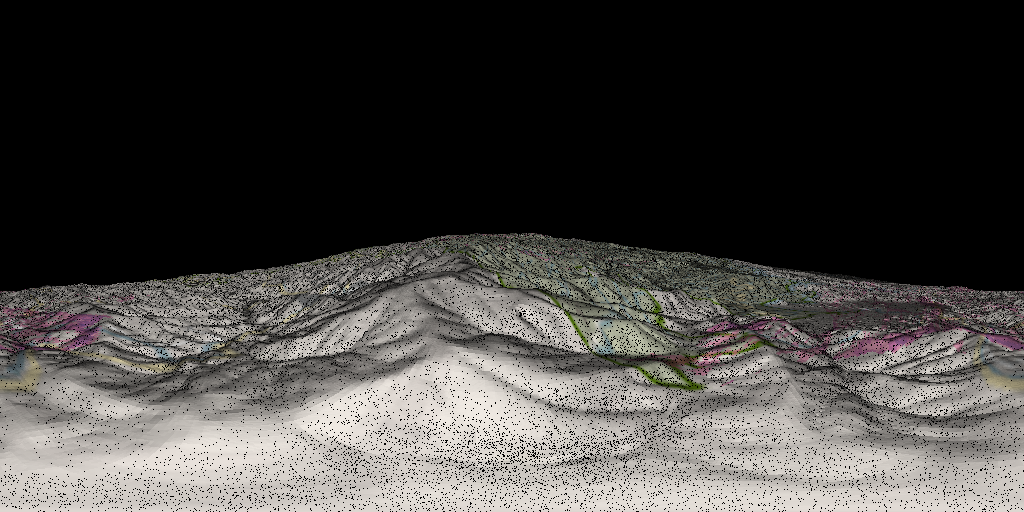

In [90]:
@run(scope='render', after=auto.IPython.display.display)
def __render(lib, renderer, camera, world, views, /):
    vi = 100
    view = views[vi]
    
    lib.ospSetVec3f(camera, b'position', *view.position)
    lib.ospSetVec3f(camera, b'up', *view.up)
    lib.ospSetVec3f(camera, b'direction', *view.direction)
    lib.ospCommit(camera)
    
    lib.ospSetVec3f(renderer, b'backgroundColor', *(
#         0.7, 0.3, 0.7,
        0.0, 0.0, 0.0
    ))
    lib.ospCommit(renderer)
    
    w, h = 1024, 512

    framebuffer = lib.ospNewFrameBuffer(w, h, lib.OSP_FB_RGBA8, lib.OSP_FB_COLOR)
    _: float = lib.ospRenderFrameBlocking(
        framebuffer,
        renderer,
        camera,
        world,
    )

    rgba = lib.ospMapFrameBuffer(framebuffer, lib.OSP_FB_COLOR)
    image = auto.PIL.Image.frombytes(
        'RGB',
        (w, h),
        auto.ctypes.string_at(rgba, size=(w * h * 4)),
        'raw',
        'RGBX',
        0,
        -1,  # flip y
    )

    lib.ospUnmapFrameBuffer(rgba, framebuffer)

    return image

### Render Animation

In [199]:
@run(scope='render')
def animation():
    @auto.mediocreatbest.coroutine
    def animation(*, width: int, height: int) -> Generator[None, auto.PIL.Image.Image, None]:
        canvas = auto.ipycanvas.Canvas(width=width, height=height)
        auto.IPython.display.display(canvas)
        
        while True:
            image = yield
            image = auto.numpy.array(image)
            with auto.ipycanvas.hold_canvas():
                canvas.put_image_data(image)

    return animation

In [200]:
@run(scope='render')
def ffmpeg():
    @auto.mediocreatbest.coroutine
    def ffmpeg(
        path: auto.pathlib.Path,
        /,
    ) -> Generator[None, auto.PIL.Image.Image, None]:
        process = None
        
        try:
            # Thanks https://stackoverflow.com/a/43871666
            process = auto.subprocess.Popen(
                args=[
                    'ffmpeg',
                    '-f', 'image2pipe',
                    '-vcodec', 'png',
                    '-r', '30',  # FPS
                    '-i', '-',
                    '-c:v', 'libx264',
                    '-crf', '23',
                    '-profile:v', 'baseline',
                    '-level', '3.0',
                    '-pix_fmt', 'yuv420p',
                    '-movflags', 'faststart',
                    '-y',  # overwrite
                    path,
                ],
                stdin=auto.subprocess.PIPE,
                stdout=auto.subprocess.DEVNULL,
                stderr=auto.subprocess.DEVNULL,
            )
            
            while True:
                image = yield
                
                image.save(process.stdin, format='PNG')
                process.stdin.flush()
        
        finally:
            if process is not None:
                try:
                    process.stdin.close()
                    process.wait(timeout=10)
                    
                except:
                    process.kill()
                    
    return ffmpeg


In [201]:
@run(scope='render')
def render(lib, renderer, camera, world, /):
    @auto.mediocreatbest.coroutine
    def render(
        *,
        width: int,
        height: int,
    ) -> Generator[auto.PIL.Image.Image, View, None]:
        framebuffer = lib.ospNewFrameBuffer(width, height, lib.OSP_FB_RGBA8, lib.OSP_FB_COLOR)
        
        image = None
        while True:
            view = yield image
            
            lib.ospSetVec3f(camera, b'position', *view.position)
            lib.ospSetVec3f(camera, b'up', *view.up)
            lib.ospSetVec3f(camera, b'direction', *view.direction)
            lib.ospCommit(camera)

            lib.ospSetVec3f(renderer, b'backgroundColor', *(
        #         0.7, 0.3, 0.7,
                0.0, 0.0, 0.0
            ))
            lib.ospCommit(renderer)
            
            _: float = lib.ospRenderFrameBlocking(
                framebuffer,
                renderer,
                camera,
                world,
            )

            rgba = lib.ospMapFrameBuffer(framebuffer, lib.OSP_FB_COLOR)
            image = auto.PIL.Image.frombytes(
                'RGB',
                (width, height),
                auto.ctypes.string_at(rgba, size=(width * height * 4)),
                'raw',
                'RGBX',
                0,
                -1,  # flip y
            )

            lib.ospUnmapFrameBuffer(rgba, framebuffer)
    
    return render


In [203]:
@run(scope='render', after=auto.IPython.display.display)
def __animation(render, ffmpeg, animation, views, /):
    width, height = 1024, 512
    
    video = 'data/video.mp4'
    
    render = render(width=width, height=height)
    animation = animation(width=width, height=height)
    ffmpeg = ffmpeg(video)
    for view in auto.tqdm.auto.tqdm(views[:-30], unit='frame'):
        image = render.send(view)
        animation.send(image)
        ffmpeg.send(image)
    
    return auto.IPython.display.FileLink(video)
    

Canvas(height=512, width=1024)

  0%|          | 0/238 [00:00<?, ?frame/s]

/home/thobson2/src/Sunrise-Demo/data/video.mp4

### Figure out OSPRay equirectangular coordinates

In [121]:
@run(scope='equi')
def lib(ospray__lib, /):
    return ospray__lib

In [125]:
class StupidTuple:
    def __init__(self, names=None):
        if names is None:
            names = []
            
        self.__names = names
        self.__class = None
        
    def __getattr__(self, name):
        attr = StupidTuple(self.__names + [name])
        setattr(self, name, attr)
        return attr
    
    def __call__(self, *args, **kwargs):
        if self.__class is None:
            typename = ''.join(name[0] for name in self.__names)
            fields = self.__names
            self.__class = auto.collections.namedtuple(typename, fields)
        
        return self.__class(*args, **kwargs)

stupidtuple = StupidTuple()

In [138]:
@run(scope='equi')
def defns():
    xpos = stupidtuple.x.y.z( 1.0,  0.0,  0.0)
    zpos = stupidtuple.x.y.z( 0.0,  0.0,  1.0)
    xneg = stupidtuple.x.y.z(-1.0,  0.0,  0.0)
    zneg = stupidtuple.x.y.z( 0.0,  0.0, -1.0)
    ypos = stupidtuple.x.y.z( 0.0,  1.0,  0.0)
    yneg = stupidtuple.x.y.z( 0.0, -1.0,  0.0)
    
    green   = stupidtuple.r.g.b(0.0, 1.0, 0.0)
    orange  = stupidtuple.r.g.b(1.0, 0.5, 0.5)
    magenta = stupidtuple.r.g.b(1.0, 0.0, 1.0)
    cyan    = stupidtuple.r.g.b(0.0, 1.0, 1.0)
    yellow  = stupidtuple.r.g.b(1.0, 1.0, 0.0)
    blue    = stupidtuple.r.g.b(0.0, 0.0, 1.0)
    
    return [
        stupidtuple.name.color.position('front',  green,   xpos),
        stupidtuple.name.color.position('right',  orange,  zpos),
        stupidtuple.name.color.position('back',   magenta, xneg),
        stupidtuple.name.color.position('left',   cyan,    zneg),
        stupidtuple.name.color.position('top',    yellow,  ypos),
        stupidtuple.name.color.position('bottom', blue,    yneg),
    ]

In [160]:
def affine3f(
    *,
    scale: float | tuple[float, float, float],
    translate: tuple[float, float, float],
) -> auto.numpy.ndarray[tuple[auto.typing.Literal[12]], auto.numpy.float32]:
    # In OSPRay, the affine3f type is implemented with a weird structure. This
    # structure corresponds with the C++ types:
    # 
    # class vec3f { float x, y, z; }
    # class linear3f { vec3f vx, vy, vz; }
    # class affine3f { linear3f l; vec3f p; }
    # 
    # If I am understanding correctly, we are meant to interpret the vx, vy, and vz
    # variables as vectors that get multiplied with the x, y, and z coordinates,
    # respectively.
    # 
    # There are two ways to view this structure then: 1) as a contiguous set of 12
    # floats, and 2) as an ordinary 4x4 projection matrix.
    # 
    # For (1), we can assign names to each variable, corresponding to this C++ code:
    # 
    # float a, b, c, d, e, f, g, h, i, j, k, l;
    # auto transform = affine3f{
    #     .l = {
    #         .vx = { .x = a, .y = b, .z = c },
    #         .vy = { .x = d, .y = e, .z = f },
    #         .vz = { .x = g, .y = h, .z = i },
    #     },
    #     .p = { .x = j, .y = k, .z = l },
    # };
    # 
    # Or, using an ordinary array of floats:
    # 
    # float transform[12] = {
    #     a, b, c,
    #     d, e, f,
    #     g, h, i,
    #     j, k, l,
    # };
    # 
    # For (2), we can rearrange the a, b, ..., l variables into an ordinary matrix:
    # 
    # [ a d g j ]   [ x ]   [ x' ]
    # [ b e h k ] x [ y ] = [ y' ]
    # [ c f i l ]   [ z ]   [ z' ]
    # [ 0 0 0 1 ]   [ 1 ]   [ 1  ]
    # 
    # It's important to note that data in a float array is stored transposed compared
    # to how it is used.
    # 
    # Regardless, for the simplest use case of a scale and then translate, we are only
    # interested in a few of the variables from the larger set of variables.
    # 
    # [ sx  0   0   tx ]
    # [ 0   sy  0   ty ]
    # [ 0   0   sz  tz ]
    # [ 0   0   0   1  ]
    # 
    # which corresponds to the floats:
    # 
    # float transform[12] = {
    #     sx, 0,  0,
    #     0,  sy, 0,
    #     0,  0,  sz,
    #     tx, ty, tz,
    # };
    
    match scale:
        case (sx, sy, sz):
            pass
        case float() as s:
            sx = sy = sz = s
        case _: raise NotImplementedError(f"""Unexpected scale: {scale=!r}""")
        
    tx, ty, tz = translate
    
    return auto.numpy.array([
        sx, 0,  0,
        0,  sy, 0,
        0,  0,  sz,
        tx, ty, tz,
    ], dtype=auto.numpy.float32)

[<__main__.LP_OSPObject object at 0x7efa5f0dce40>, <__main__.LP_OSPObject object at 0x7efa5f0dddc0>, <__main__.LP_OSPObject object at 0x7efa5f0dfa40>, <__main__.LP_OSPObject object at 0x7efa5f0deb40>, <__main__.LP_OSPObject object at 0x7efa5f0de6c0>, <__main__.LP_OSPObject object at 0x7efa5f0de9c0>, <__main__.LP_OSPObject object at 0x7efa5f0dd4c0>]
Array of OSPObjects
Now an array of: array = ndarray(array([..., 94115989096864], dtype=uint64), shape=(7,), dtype=dtype('uint64'))


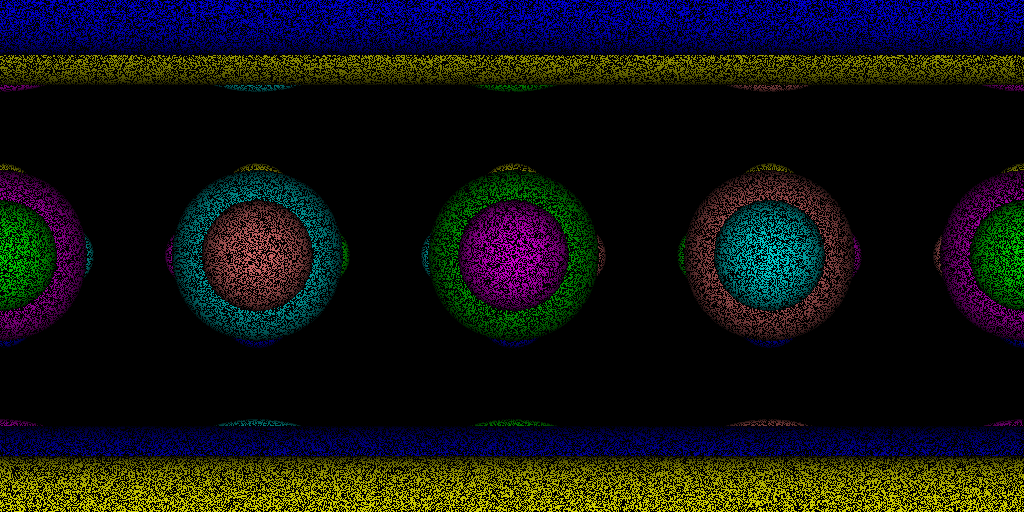

In [173]:
@run(scope='equi', after=auto.IPython.display.display)
def image(lib, defns, /):
    def Data(array: auto.numpy.ndarray, /, *, type: lib.OSPDataType) -> lib.OSPData:
        if isinstance(array, list):
            for i, x in enumerate(array):
                if not isinstance(x, lib.OSPObject):
                    break
                
            else:
                print(f'Array of OSPObjects')
                array = (auto.ctypes.cast(x, auto.ctypes.c_void_p).value for x in array)
                array = auto.numpy.fromiter(array, dtype=auto.numpy.uintp)
                print(f'Now an array of: {array = !r}')
                return Data(array, type=type)
        
            print(f'Array of other things')
            array = auto.numpy.asarray(array)
            return Data(array, type=type)
        
        if len(array.shape) == 0:
            array = array[None, None, None]

        elif len(array.shape) == 1:
            array = array[:, None, None]

        elif len(array.shape) == 2:
            array = array[:, :, None]
            
        elif len(array.shape) == 3:
            array = array[:, :, :]

        else:
            raise NotImplementedError()

        src = lib.ospNewSharedData(
            array.ctypes.data, type,
            array.shape[0], array.strides[0],
            array.shape[1], array.strides[1],
            array.shape[2], array.strides[2],
        )
        lib.ospCommit(src)

        dst = lib.ospNewData(type, *array.shape)
        lib.ospCopyData(src, dst, 0, 0, 0)
        lib.ospCommit(dst)

        lib.ospRelease(src)
        return dst
        
    with auto.contextlib.ExitStack() as stack:
        defer = stack.callback
        
        position = auto.numpy.zeros(
            shape=(len(defns), 1),
            dtype=[ ('x', 'f4'), ('y', 'f4'), ('z', 'f4') ],
        )
        for i, defn in enumerate(defns):
            position['x'][i, 0] = defn.position.x
            position['y'][i, 0] = defn.position.y
            position['z'][i, 0] = defn.position.z

        position = Data(position, type=lib.OSP_VEC3F)
        defer(lib.ospRelease, position)

        geometry = lib.ospNewGeometry(b'sphere')
        lib.ospSetObject(geometry, b'sphere.position', position)
        lib.ospSetFloat(geometry, b'radius', 0.5)
        lib.ospCommit(geometry)
        defer(lib.ospRelease, geometry)
            
        color = auto.numpy.zeros(
            shape=(len(defns), 1),
            dtype=[ ('r', 'f4'), ('g', 'f4'), ('b', 'f4'), ('a', 'f4') ]
        )
        for i, defn in enumerate(defns):
            color['r'][i, 0] = defn.color.r
            color['g'][i, 0] = defn.color.g
            color['b'][i, 0] = defn.color.b
            color['a'][i, 0] = 1.0
        
        color = Data(color, type=lib.OSP_VEC4F)
        defer(lib.ospRelease, color)
        
        material = lib.ospNewMaterial(None, b'obj')
        lib.ospCommit(material)
        defer(lib.ospRelease, material)

        model = lib.ospNewGeometricModel(None)
        lib.ospSetObject(model, b'geometry', geometry)
        lib.ospSetObject(model, b'color', color)
        lib.ospSetObject(model, b'material', material)
        lib.ospCommit(model)
        defer(lib.ospRelease, model)

        group = lib.ospNewGroup()
        lib.ospSetObjectAsData(group, b'geometry', lib.OSP_GEOMETRIC_MODEL, model)
        lib.ospCommit(group)
        defer(lib.ospRelease, group)

        @list
        @auto.mediocreatbest.immediate
        def instance():
            for defn in [
                stupidtuple.position.scale(stupidtuple.x.y.z( 0.0, 0.0, 0.0 ), 1.0),
            ] + [
                stupidtuple.position.scale(defn.position, 0.4)
                for defn in defns
            ]:
                transform = affine3f(scale=defn.scale, translate=defn.position)
                
                instance = lib.ospNewInstance(None)
                lib.ospSetObject(instance, b'group', group)
                lib.ospSetParam(instance, b'transform', lib.OSP_AFFINE3F, transform.ctypes.data)
                lib.ospCommit(instance)
                defer(lib.ospRelease, instance)
                
                yield instance

        print(instance)

        instance = Data(instance, type=lib.OSP_INSTANCE)
        defer(lib.ospRelease, instance)

        world = lib.ospNewWorld()
        lib.ospSetObject(world, b'instance', instance)
        lib.ospCommit(world)
        defer(lib.ospRelease, world)

        camera = lib.ospNewCamera(b'panoramic')
        lib.ospSetVec3f(camera, b'position', 0.0, 0.0, 0.0)
        lib.ospSetVec3f(camera, b'direction', 1.0, 0.0, 0.0)
        lib.ospSetVec3f(camera, b'up', 0.0, 1.0, 0.0)
        lib.ospCommit(camera)
        defer(lib.ospRelease, camera)

        renderer = lib.ospNewRenderer(b'ao')
        lib.ospCommit(renderer)
        defer(lib.ospRelease, renderer)

        w, h = 1024, 512

        framebuffer = lib.ospNewFrameBuffer(w, h, lib.OSP_FB_RGBA8, lib.OSP_FB_COLOR)
        defer(lib.ospRelease, framebuffer)
        
        _: float = lib.ospRenderFrameBlocking(
            framebuffer,
            renderer,
            camera,
            world,
        )

        rgba = lib.ospMapFrameBuffer(framebuffer, lib.OSP_FB_COLOR)
        defer(lib.ospUnmapFrameBuffer, rgba, framebuffer)
        
        image = auto.PIL.Image.frombytes(
            'RGB',
            (w, h),
            auto.ctypes.string_at(rgba, size=(w * h * 4)),
            'raw',
            'RGBX',
            0,
            -1,  # flip y
        )

        return image
    

## Sunrise-as-a-Service

In [50]:
@run(scope='service')
def render(render__render, /):
    return render__render

In [209]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Request:
    path: str
    query: dict[AnyStr, AnyStr]

@auto.dataclasses.dataclass(eq=True, frozen=True)
class Response:
    status: int
    content_type: str
    data: AnyStr | dict[AnyStr, AnyStr]

@run(scope='service')
def server():
    patchbay = 'https://patchbay.pub'
    
    def server(*, primary: str, verbose=False):
        def http(*, method, url, data=None, headers=None) -> auto.requests.Response:
            if verbose:
                print(f'http(\n  {method=!r},\n  {url=!r},\n  {data=!r},\n  {headers=!r},\n)')

            return auto.requests.request(
                method=method,
                url=url,
                data=data,
                headers=headers,
            )
        
        secondary = auto.uuid.uuid4().hex

        print(f'Listening at {auto.urllib.parse.urljoin(patchbay, f"/req/{primary}/")}')
        while True:
            with http(
                method='POST',
                url=auto.urllib.parse.urljoin(patchbay, f'/res/{primary}?switch=true'),
                data=f'{secondary}',
            ) as r:
                r.raise_for_status()
                
                uri = r.headers['pb-uri']
                uri = auto.urllib.parse.urljoin(patchbay, uri)
                _scheme, _netloc, path, _params, query, _fragment = auto.urllib.parse.urlparse(uri)
                query = auto.urllib.parse.parse_qs(query)
                path = path.removeprefix(f'/req/{primary}')
                request = Request(
                    path=path,
                    query=query,
                )
                
            response = yield request
            if response is None:
                response = Response(
                    status=500,
                    content_type='text/plain',
                    data=b'500 Internal Server Error',
                )
            
            with http(
                method='POST',
                url=auto.urllib.parse.urljoin(patchbay, f'/{secondary}'),
                data=response.data,
                headers={
                    'Pb-Status': str(response.status),
                    'Pb-H-Content-Type': response.content_type,
                },
            ) as r:
                r.raise_for_status()

    return server
    

In [221]:
%%verbatim -v __index_html
<!DOCTYPE html>
<meta charset="UTF-8">
<title></title>
<style>
* {
    margin: 0;
    padding: 0;
    box-sizing: border-box;
}
</style>
<div id=app>
</div>
<script async src="https://unpkg.com/es-module-shims@1.6.3/dist/es-module-shims.js"></script>
<script type="importmap">
{
    "imports": {
        "three": "https://unpkg.com/three@${THREE_VERSION}/build/three.module.js",
        "three/addons/": "https://unpkg.com/three@${THREE_VERSION}/examples/jsm/"
    }
}
</script>
<script src="https://unpkg.com/@babel/standalone@7.22.9/babel.min.js"></script>
<script type="text/babel" data-plugins="syntax-do-expressions,proposal-do-expressions" data-type="module">
import * as THREE from 'three';
import { ARButton } from 'three/addons/webxr/ARButton.js';
import { TrackballControls } from 'three/addons/controls/TrackballControls.js';



const renderer = do {
    const alpha = true;
    const antialias = true;
    new THREE.WebGLRenderer({ alpha, antialias });
};
renderer.setPixelRatio(window.devicePixelRatio);
renderer.setSize(window.innerWidth, window.innerHeight);
renderer.autoClear = false;
renderer.xr.enabled = true;
renderer.setAnimationLoop(render);
document.body.appendChild(renderer.domElement);

{
    const button = ARButton.createButton(renderer);
    document.body.appendChild(button);
};

const scene = do {
    new THREE.Scene();
};
scene.background = new THREE.Color(0x505050);

const camera = do {
    const fov = 77;
    const aspect = do {
        const { x: width, y: height } = renderer.getSize(new THREE.Vector2());
        width / height;
    };
    const near = 0.1;
    const far = 100.0;
    new THREE.PerspectiveCamera(fov, aspect, near, far);
};
camera.position.set(0.0, 0.0, 0.0);
camera.up.set(0.0, 1.0, 0.0);
camera.lookAt(1.0, 0.0, 0.0);

const textureLoader = do {
    new THREE.TextureLoader();
};

const controls = do {
    const camera_ = do {
        camera.clone();
    };
    camera_.position.set(1.0, 0.0, 0.0);
    camera_.up.set(0.0, -1.0, 0.0);
    const domElement = renderer.domElement;
    new TrackballControls(camera_, domElement);
};
controls.target.set(0.0, 0.0, 0.0);

const mesh = do {
    const geometry = do {
        const radius = 1.0;
        const widthSegments = 60;
        const heightSegments = 40;
        new THREE.SphereGeometry(radius, widthSegments, heightSegments);
    };
    geometry.scale(-1.0, 1.0, 1.0); // make all faces point inwards
    geometry.rotateY(Math.PI);
//     geometry.rotateX(Math.PI);
    const material = do {
        const map = do {
            const position = [563.2271446178601, 3706.84551063691, -5153.367883611318]
            const up = [563.2271446178601, 3706.84551063691, -5153.367883611318]
            const direction = [3.3002321090438045, 0.29997060238702034, 1.1959763137756454]
            const params = new URLSearchParams();
            params.set('position', `${position}`);
            params.set('up', `${up}`);
            params.set('direction', `${direction}`);
            const url = `api/v1/view/?${params}`;
            textureLoader.load(url);
        };
        new THREE.MeshBasicMaterial({ map });
    };
    new THREE.Mesh(geometry, material);
};
scene.add(mesh);

function render() {
    if (!renderer.xr.isPresenting) {
        controls.update();
        {
            const src = controls.object.position;
            camera.lookAt(src.x, -src.y, src.z);
        }
//        {
//            const src = controls.object.up.clone();
//            // src.multiplyScalar(-1.0);
//            const dst = camera.up;
//            dst.copy(src);
//        }
    }
    
    renderer.render(scene, camera);
}

</script>


In [226]:
@run(scope='service')
def __service(render, server, fetch, /):
    def index(request: Request, /) -> Response:
        html = __index_html
        html = auto.string.Template(html)
        html = html.safe_substitute(
            THREE_VERSION='0.155.0',
        )
        
        return Response(
            status=200,
            content_type='text/html',
            data=html,
        )

    def panoramic(request: Request, /) -> Response:
        image = fetch((
            r"""https://cycling74-web-uploads.s3.amazonaws.com/"""
            r"""6187b6553cbf2d1585a07a79/2022-05-16T00:46:05Z/equirectangular_test_image.jpg"""
        ))
        
#         with auto.io.BytesIO() as f:
#             run.g['equi__image'].save(f, 'JPEG')
#             image = f.getvalue()
        
        return Response(
            status=200,
            content_type='image/jpg',
            data=image,
        )
    
    def view(request: Request, /, *, render) -> Response:
        print(request.query)
        position = tuple(map(float, request.query['position'][0].split(',')))
        up = tuple(map(float, request.query['up'][0].split(',')))
        direction = tuple(map(float, request.query['direction'][0].split(',')))

        view = View(
            position=position,
            up=up,
            direction=direction,
        )

        image = render.send(view)

        with auto.io.BytesIO() as f:
            image.save(f, format='JPEG')

            image = f.getvalue()

        return Response(
            status=200,
            content_type='image/jpg',
            data=image,
        )
    
    with auto.contextlib.ExitStack() as stack:
        enter = stack.enter_context
        closing = auto.contextlib.closing
        
        enter( auto.contextlib.suppress(KeyboardInterrupt) )
        
        server = enter(closing( server(primary='sunrise') ))
        render = enter(closing( render(width=512, height=512) ))
        
        response = None
        while True:
            request = server.send(response)

            response = None
            if request.path == '/':
                response = index(request)
            
            elif request.path == '/static/panoramic.jpg':
                response = panoramic(request)

            elif request.path == '/api/v1/view/':
                response = view(request, render=render)

            else:
                raise NotImplementedError(f'''Unexpected path: {request.path=!r}''')
    

Listening at https://patchbay.pub/req/sunrise/
{'position': ['563.2271446178601,3706.84551063691,-5153.367883611318'], 'up': ['563.2271446178601,3706.84551063691,-5153.367883611318'], 'direction': ['3.3002321090438045,0.29997060238702034,1.1959763137756454']}


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

## Test

In [ ]:
@run
def __build():
    def ppargs(args: list, /) -> list:
        print(f'$ {auto.shlex.join(map(str, args))}')
        return args
    
    auto.subprocess.run(
        args=ppargs([
            '/home/thobson2/src/Sunrise-Demo/go.sh', 'build',
        ]),
        stdin=auto.subprocess.DEVNULL,
        capture_output=False,
        bufsize=1,
        check=True,
    )

In [ ]:

        
@run(scope='render')
def __render(cameras, /):
    def ppargs(args: list, /) -> list:
        print(f'$ {auto.shlex.join(map(str, args))}')
        return args
    
#     auto.subprocess.run(
#         args=ppargs([
#             './go.sh', 'build',
#         ]),
#         stdin=auto.subprocess.DEVNULL,
#         check=True,
#     )

    @auto.mediocreatbest.contextgenerator
    def renderer():
        with auto.subprocess.Popen(
            args=ppargs([
                './go.sh', 'main',
            ]),
            stdin=auto.subprocess.PIPE,
            stdout=auto.subprocess.PIPE,
            stderr=auto.subprocess.DEVNULL,
        ) as process:
            def write(s: str, /):
    #             print(f'write({s!r})')
                process.stdin.write(s.encode('utf-8'))
                process.stdin.write(b'\n')
                process.stdin.flush()

            def read() -> bytes:
                def read(format, /) -> tuple[Any]:
                    size = auto.struct.calcsize(format)
                    data = process.stdout.read(size)
                    assert len(data) == size, \
                        f"""Didn't read the entire buffer: {len(data)=!r} {size=!r}"""
                    return auto.struct.unpack(format, data)

                count ,= read('N')
    #             print(f'Reading {count} bytes')
                data ,= read(f'{count}s')
                return data

            image = None
            while True:
                camera = yield image
                write('camera')
                write(' '.join(map(str, camera.position)))
                write(' '.join(map(str, camera.up)))
                write(' '.join(map(str, camera.direction)))
                write(' '.join(map(str, (
                    # imageStart
                    0, 0
                ))))
                write(' '.join(map(str, (
                    # imageEnd
                    1, 1
                ))))

                write('render')

                image = read()
    
    def cameras() -> list[Camera]:
        with open(auto.pathlib.Path.cwd() / 'data' / 'Appalachian_Trail.json', 'r') as f:
            trail = auto.json.load(f)
        
#         trail = trail[::8]
        
        cameras = []
        for window in auto.more_itertools.sliding_window(trail, 3 * (k := 4)):
            srcs = window[:k]
            tgts = window[-k:]
            assert len(srcs) == k
            assert len(tgts) == k
            
            src_lat = auto.statistics.fmean(src["lat"] for src in srcs)
            src_lng = auto.statistics.fmean(src["lng"] for src in srcs)
            src_alt: Meter = 2_000 # * auto.random.uniform(0.9, 1.1)

            tgt_lat = auto.statistics.fmean(tgt["lat"] for tgt in tgts)
            tgt_lng = auto.statistics.fmean(tgt["lng"] for tgt in tgts)
            tgt_alt: Meter = 1_500 # * auto.random.uniform(0.9, 1.1)

            src_x, src_y, src_z = map(lambda x: x/1000, convert_location_to_spatial(
                lat=src_lat,
                lng=src_lng,
                alt=src_alt,
            ))

            tgt_x, tgt_y, tgt_z = map(lambda x: x/1000, convert_location_to_spatial(
                lat=tgt_lat,
                lng=tgt_lng,
                alt=tgt_alt,
            ))
            
            cameras.append(Camera(
                position=(
                    src_x,
                    src_y,
                    src_z,
                ),
                up=(
                    src_x,
                    src_y,
                    src_z,
                ),
                direction=(
                    tgt_x - src_x,
                    tgt_y - src_y,
                    tgt_z - src_z,
                ),
            ))
        
        return cameras
    
    @auto.mediocreatbest.contextgenerator
    def display():
        handle = auto.IPython.display.display(None, display_id=True)
        
        while True:
            obj = yield
            handle.update(obj)
    
    @auto.mediocreatbest.contextgenerator
    def ffmpeg():
        # Thanks https://stackoverflow.com/a/43871666
        process = None
        
        try:
            process = auto.subprocess.Popen(
                args=ppargs([
                    'ffmpeg',
                    '-f', 'image2pipe',
                    '-vcodec', 'png',
                    '-r', '30',  # FPS
                    '-i', '-',
                    '-vcodec', 'libx264',
                    '-qscale', '0',
                    '-y',  # overwrite
                    auto.pathlib.Path.cwd() / 'data' / 'video.mp4',
                ]),
                stdin=auto.subprocess.PIPE,
                stdout=auto.subprocess.DEVNULL,
                stderr=auto.subprocess.DEVNULL,
            )
            
            while True:
                image = yield

                process.stdin.write(image)
                process.stdin.flush()
        
        finally:
            if process is not None:
                try:
                    process.stdin.close()
                    process.wait(timeout=10)
                    
                except:
                    process.kill()

    DO_SHOW = (
        False
#         True
    )
    DO_SAVE = (
#         False
        True
    )
            
    cameras = cameras()
    with auto.contextlib.ExitStack() as stack:
        renderer = stack.enter_context(renderer())
        
        if DO_SHOW:
            display = stack.enter_context(display())
        
        if DO_SAVE:
            ffmpeg = stack.enter_context(ffmpeg())
        
        for i, camera in auto.tqdm.auto.tqdm(enumerate(cameras), total=len(cameras), unit='frame'):
            image = renderer.send(camera)

            if DO_SHOW:
                display.send(auto.IPython.display.Image(image, width=512, height=512))

            if DO_SAVE:
                ffmpeg.send(image)

In [ ]:
@auto.IPython.core.magic.register_cell_magic
def verbatim(line, cell=None):
    def verbatim(*, variable: str):
        get_ipython().push({
            variable: cell,
        })
    
    parser = auto.argparse.ArgumentParser()
    parser.add_argument('-v', dest='variable', default='verbvatim')
    args = vars(parser.parse_args(auto.shlex.split(line)))
    
    return verbatim(**args)

del verbatim

In [ ]:
%%verbatim -v __index_html
<!DOCTYPE html>
<h1>Howdy world

In [ ]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Request:
    path: str
    params: dict[AnyStr, AnyStr]

@auto.dataclasses.dataclass(eq=True, frozen=True)
class Response:
    status: int
    content_type: str
    data: AnyStr | dict[AnyStr, AnyStr]

@run
def __web_server():
    patchbay = 'https://patchbay.pub'
    
    def http(*, method, url, data=None, headers=None) -> auto.requests.Response:
        print(f'http(\n  {method=!r},\n  {url=!r},\n  {data=!r},\n  {headers=!r},\n)')
        return auto.requests.request(
            method=method,
            url=url,
            data=data,
            headers=headers,
        )
    
    @auto.mediocreatbest.immediate
#     @auto.mediocreatbest.coroutine
    def server():
        primary = '6unx-6fgr'
        secondary = auto.uuid.uuid4().hex
        
        while True:
            with http(
                method='POST',
                url=auto.urllib.parse.urljoin(patchbay, f'/res/{primary}?switch=true'),
                data=f'{secondary}',
            ) as r:
                r.raise_for_status()
                
                path = r.headers['pb-uri']
                path = path.removeprefix(f'/req/{primary}')
#                 path = # split path and query
                request = Request(
                    path=
                )
                
            response = yield request
            if response is None:
                response = Response(
                    status=500,
                    content_type='text/plain',
                    data=b'500 Internal Server Error',
                )
            
            with http(
                method='POST',
                url=auto.urllib.parse.urljoin(patchbay, f'/{secondary}'),
                data=response.data,
                headers={
                    'Pb-Status': str(response.status),
                    'Pb-H-Content-Type': response.content_type,
                },
            ) as r:
                r.raise_for_status()
    
    response = None
    while True:
        request = server.send(response)
        
        response = None
        if request.path == '/':
            response = Response(
                status=200,
                content_type='text/html',
                data=__index_html,
            )
        
        elif request.path.startswith('/api/v1/sunrise/'):
            
            
        if response is None:
            print(f'Unexpected path: {request.path=!r}')
    